# 1 Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import itertools
import random # split datasets
# from sklearn.utils import resample
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, roc_auc_score

# Optuna
import optuna 
import optuna.integration.lightgbm as lgb

# xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier

# lightgbm
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation


# bayesian
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# graphviz
from sklearn import tree
from xgboost import plot_tree
from lightgbm import plot_tree

# dtreeviz
import dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

# 2 Load datasets

In [2]:
# train = pd.read_csv('data/train_after_missing_value_without_dropping_rows.csv')
# test = pd.read_csv('data/test_after_missing_value_without_dropping_rows.csv')
train = pd.read_csv('data/train_in_join_after_missing_value.csv')
test = pd.read_csv('data/test_in_join_after_missing_value.csv')


In [3]:
# drop the redundant columns
train.drop(columns=["Unnamed: 0"], inplace = True)
test.drop(columns=["Unnamed: 0"], inplace = True)

In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
## Reducing memory of train sets
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 123.25 Mb (73.5% reduction)
Mem. usage decreased to 123.15 Mb (73.0% reduction)


For avoiding LightGBM error: `LightGBMError: Do not support special JSON characters in feature name., rename the features`

In [6]:
import re
train = train.rename(columns = lambda x:re.sub(':', '', x))
test = test.rename(columns = lambda x:re.sub(':', '', x))

Train / Validation Split

In [7]:
y = pd.DataFrame(train['isFraud'])
y[['isFraud']] = y[['isFraud']].astype(np.int8) # for visualization by dtreeviz
X = train.drop(columns=['isFraud'])

X_test = test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [8]:
y_val1 = y_val['isFraud'].values

In [9]:
del train,test

Directly jump to the 3.1.2 and 3.2.2 to get best_param (Assign value to best_param)

# 3 Hyperparameter tuning

## 3.1 XGBoost

In [74]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

def objective(trial):
    param = {
        "verbosity": 0,
        # 'eval_metric' : 'rocauc',
        "objective": "binary:logistic",
        "booster": "gbtree",
        "eta": trial.suggest_float("eta", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 14, step=1),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10, step = 1),
    }
    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    roc_auc = sklearn.metrics.roc_auc_score(y_val, pred_labels)
    return roc_auc

### 3.1.1 study

study - TPE

In [75]:
%%time
# TPE
study_tpe = optuna.create_study(direction="maximize")
study_tpe.optimize(objective, n_trials=1000, timeout=600)

print("Number of finished trials: ", len(study_tpe.trials))
# print("Best trial:")
# trial = study.best_trial

[I 2023-03-06 23:20:42,811] A new study created in memory with name: no-name-ca493ce0-4135-42fd-9d33-e244a1c2dabc
[I 2023-03-06 23:20:44,170] Trial 0 finished with value: 0.7330438964992506 and parameters: {'eta': 0.058054811506340356, 'subsample': 0.37764688827430987, 'colsample_bytree': 0.30530784979815967, 'max_depth': 9, 'min_child_weight': 10}. Best is trial 0 with value: 0.7330438964992506.
[I 2023-03-06 23:20:46,561] Trial 1 finished with value: 0.8327370581476251 and parameters: {'eta': 0.950800393376354, 'subsample': 0.9360426087623905, 'colsample_bytree': 0.9619939676106739, 'max_depth': 9, 'min_child_weight': 6}. Best is trial 1 with value: 0.8327370581476251.
[W 2023-03-06 23:20:47,123] Trial 2 failed with parameters: {'eta': 0.49720518262974656, 'subsample': 0.47087423159538144, 'colsample_bytree': 0.7517986778633128, 'max_depth': 2, 'min_child_weight': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Python310\lib\site-

KeyboardInterrupt: 

study - CMAES

In [76]:
%%time
# CMA-ES
study_cmaes = optuna.create_study(direction="maximize", sampler= optuna.samplers.CmaEsSampler())
study_cmaes.optimize(objective, n_trials=10000, timeout=600)
print("Number of finished trials: ", len(study_cmaes.trials))

# Number of finished trials:  276
# CPU times: total: 1h 50min 32s
# Wall time: 10min

[I 2023-03-06 23:20:51,477] A new study created in memory with name: no-name-880a88dd-8788-43a5-897c-e12182753362
[I 2023-03-06 23:20:52,488] Trial 0 finished with value: 0.7873233872513223 and parameters: {'eta': 0.5668369957987125, 'subsample': 0.5127103020503784, 'colsample_bytree': 0.4471323402296685, 'max_depth': 5, 'min_child_weight': 5}. Best is trial 0 with value: 0.7873233872513223.
[I 2023-03-06 23:20:54,043] Trial 1 finished with value: 0.7567640359725765 and parameters: {'eta': 0.08869109429186427, 'subsample': 0.46889798517510506, 'colsample_bytree': 0.5735201469541877, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 0 with value: 0.7873233872513223.
[I 2023-03-06 23:20:55,492] Trial 2 finished with value: 0.7567268067702528 and parameters: {'eta': 0.11146404743080462, 'subsample': 0.5984938060675729, 'colsample_bytree': 0.4970483430404295, 'max_depth': 8, 'min_child_weight': 6}. Best is trial 0 with value: 0.7873233872513223.
[I 2023-03-06 23:20:56,885] Trial 3 fini

Number of finished trials:  311
CPU times: total: 1h 51min 16s
Wall time: 10min


### 3.1.2 best params

In [59]:
# xgboost - tpe
study_tpe.best_params 

{'eta': 0.9609695336041312,
 'subsample': 0.9856832859112405,
 'colsample_bytree': 0.8929868571142427,
 'max_depth': 14,
 'min_child_weight': 3}

In [87]:
# xgboost - cmaes
study_cmaes.best_params

{'eta': 0.2816835863349672,
 'subsample': 0.8517385509346191,
 'colsample_bytree': 0.8355448129450843,
 'max_depth': 8,
 'min_child_weight': 6}

Assign value to best_param

In [66]:
# xgboost - tpe
xgb_best_param_tpe = {'eta': 0.9609695336041312,
 'subsample': 0.9856832859112405,
 'colsample_bytree': 0.8929868571142427,
 'max_depth': 14,
 'min_child_weight': 3}

# xgboost - cmaes
xgb_best_param_cmaes = {'eta': 0.8425267355759116,
 'subsample': 0.5312647485372584,
 'colsample_bytree': 0.5151544764131928,
 'max_depth': 13,
 'min_child_weight': 7}

### 3.1.3 traning

In [15]:
# tpe
xgb_model_tpe = xgb.train(params=xgb_best_param_tpe, dtrain=dtrain)

In [16]:
# cmaes
xgb_model_cmaes = xgb.train(params=xgb_best_param_cmaes, dtrain=dtrain)

### 3.1.4 prediction

In [17]:
# tpe
y_pred_xgb_tpe = xgb_model_tpe.predict(xgb.DMatrix(X_val))
y_pred_xgb_tpe = (y_pred_xgb_tpe > 0.5).astype(int)

In [18]:
# cmaes
y_pred_xgb_cmaes = xgb_model_cmaes.predict(xgb.DMatrix(X_val))
y_pred_xgb_cmaes = (y_pred_xgb_cmaes > 0.5).astype(int)

## 3.2 LightGBM

In [19]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val)

def objective(trial):    
    params = {
        "objective": "binary",
        "metric": "aucroc",
        "boosting_type": "gbdt",
        "verbosity": -2,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.1, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        'feature_fraction': trial.suggest_float("feature_fraction",0.1, 1),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.1, 1),
        # "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "random_state": trial.suggest_int("random_state", 50, 1000, step=50) 
    }
    lgb_model = lgb.train(params, train_data)
    preds = lgb_model.predict(X_val)
    pred_labels = np.rint(preds)
    roc_auc = sklearn.metrics.roc_auc_score(y_val, pred_labels)
    return roc_auc

### 3.2.1 study

study - TPE

In [22]:
%%time
study_tpe_lgb = optuna.create_study(direction="maximize")
study_tpe_lgb.optimize(objective, n_trials=1000, timeout=600)
print("Number of finished trials: ", len(study_tpe_lgb.trials))

[I 2023-03-06 21:49:54,194] A new study created in memory with name: no-name-b4120426-89f0-432d-ab7b-d3eaa1958227
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:49:56,057] Trial 0 finished with value: 0.8285604297182787 and parameters: {'learning_rate': 0.10306816688791018, 'num_leaves': 225, 'max_depth': 7, 'feature_fraction': 0.4433515919629071, 'bagging_fraction': 0.7529373814199375, 'subsample': 0.7909915448715605, 'colsample_bytree': 0.5543938072053429, 'reg_alpha': 7.972635056481835, 'reg_lambda': 0.8481008375860299, 'random_state': 400}. Best is trial 0 with value: 0.8285604297182787.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:49:58,770] Trial 1 finished with value: 0.8673551777974594 and parameters: {'learning_rate': 0.8147806227756004, 'num_leaves': 427, 'max_depth': 13, 'feature_fraction': 0.7126814559481883, 'bagging_fraction': 0.6903156180609237, 'subsample': 0.950324226520086, 'colsample_bytree': 0.5790367842632234, 'reg_alpha': 5.182994291622159, 'reg_lambda': 8.722245202707523, 'random_state': 50}. Best is trial 1 with value: 0.8673551777974594.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:02,733] Trial 2 finished with value: 0.8706078688009001 and parameters: {'learning_rate': 0.1746198737528268, 'num_leaves': 447, 'max_depth': 13, 'feature_fraction': 0.5284480466238188, 'bagging_fraction': 0.6752919916986551, 'subsample': 0.7268671062222964, 'colsample_bytree': 0.40167303522547776, 'reg_alpha': 0.29048544922915087, 'reg_lambda': 6.373850817302795, 'random_state': 600}. Best is trial 2 with value: 0.8706078688009001.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:03,525] Trial 3 finished with value: 0.8087628977167794 and parameters: {'learning_rate': 0.35096982584474046, 'num_leaves': 489, 'max_depth': 3, 'feature_fraction': 0.21294340761416292, 'bagging_fraction': 0.8258316086910233, 'subsample': 0.3027678105766364, 'colsample_bytree': 0.8654537115234937, 'reg_alpha': 0.6582992089931017, 'reg_lambda': 8.960995832999574, 'random_state': 900}. Best is trial 2 with value: 0.8706078688009001.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:06,707] Trial 4 finished with value: 0.8768711637453785 and parameters: {'learning_rate': 0.3060197568660801, 'num_leaves': 354, 'max_depth': 14, 'feature_fraction': 0.4116088429535132, 'bagging_fraction': 0.11305073367745636, 'subsample': 0.8736393470200019, 'colsample_bytree': 0.6295121134076611, 'reg_alpha': 2.385359867425403, 'reg_lambda': 6.1552384397347835, 'random_state': 950}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:07,916] Trial 5 finished with value: 0.8459886835408372 and parameters: {'learning_rate': 0.19930368587273875, 'num_leaves': 294, 'max_depth': 9, 'feature_fraction': 0.16415779003845432, 'bagging_fraction': 0.8139330166931189, 'subsample': 0.20555188934988122, 'colsample_bytree': 0.9125121288390654, 'reg_alpha': 7.086617328611359, 'reg_lambda': 4.510331446023992, 'random_state': 950}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:10,720] Trial 6 finished with value: 0.8681209397371397 and parameters: {'learning_rate': 0.26615995417824273, 'num_leaves': 283, 'max_depth': 12, 'feature_fraction': 0.7929570834102487, 'bagging_fraction': 0.2538734314077225, 'subsample': 0.938292832378834, 'colsample_bytree': 0.656954516673086, 'reg_alpha': 9.041870726607483, 'reg_lambda': 6.140621566108683, 'random_state': 300}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:11,661] Trial 7 finished with value: 0.7617903452572005 and parameters: {'learning_rate': 0.1696590187668366, 'num_leaves': 278, 'max_depth': 2, 'feature_fraction': 0.510830365685894, 'bagging_fraction': 0.2817400833026904, 'subsample': 0.798630740970615, 'colsample_bytree': 0.913842188802515, 'reg_alpha': 6.53116620352707, 'reg_lambda': 2.550688740123399, 'random_state': 450}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:14,620] Trial 8 finished with value: 0.8638258384080583 and parameters: {'learning_rate': 0.14716562644253403, 'num_leaves': 180, 'max_depth': 12, 'feature_fraction': 0.8828902821254824, 'bagging_fraction': 0.15779228528138922, 'subsample': 0.655039624290165, 'colsample_bytree': 0.6787728108130902, 'reg_alpha': 5.274990744885412, 'reg_lambda': 7.510901423594095, 'random_state': 850}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:16,933] Trial 9 finished with value: 0.8674849644114145 and parameters: {'learning_rate': 0.7434640315741226, 'num_leaves': 201, 'max_depth': 13, 'feature_fraction': 0.7569588329279527, 'bagging_fraction': 0.8844150003466518, 'subsample': 0.8011337777779481, 'colsample_bytree': 0.9290492367719287, 'reg_alpha': 7.467877588488108, 'reg_lambda': 7.159216785070552, 'random_state': 750}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:18,637] Trial 10 finished with value: 0.8717562052896821 and parameters: {'learning_rate': 0.4360834834544337, 'num_leaves': 101, 'max_depth': 9, 'feature_fraction': 0.33818227187663435, 'bagging_fraction': 0.4419683784293268, 'subsample': 0.5539982437745923, 'colsample_bytree': 0.21115442613196972, 'reg_alpha': 2.63077593370564, 'reg_lambda': 4.208395650978048, 'random_state': 650}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:20,309] Trial 11 finished with value: 0.8692406855196325 and parameters: {'learning_rate': 0.43143963307885885, 'num_leaves': 127, 'max_depth': 8, 'feature_fraction': 0.34160969828065446, 'bagging_fraction': 0.46293535291003796, 'subsample': 0.5233270621594843, 'colsample_bytree': 0.22968223663869114, 'reg_alpha': 2.221468230080524, 'reg_lambda': 4.72988882794872, 'random_state': 650}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:22,444] Trial 12 finished with value: 0.8730762878502181 and parameters: {'learning_rate': 0.511704938276905, 'num_leaves': 370, 'max_depth': 10, 'feature_fraction': 0.3601726544249136, 'bagging_fraction': 0.45113162148044383, 'subsample': 0.5341972770930646, 'colsample_bytree': 0.2585817824820959, 'reg_alpha': 3.152763893604286, 'reg_lambda': 3.6602751551733874, 'random_state': 1000}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:23,537] Trial 13 finished with value: 0.8582886101561895 and parameters: {'learning_rate': 0.5651325619744204, 'num_leaves': 368, 'max_depth': 5, 'feature_fraction': 0.6127568473123111, 'bagging_fraction': 0.1484758490922438, 'subsample': 0.46654128609110956, 'colsample_bytree': 0.40980960504124353, 'reg_alpha': 3.4064272317840207, 'reg_lambda': 3.1686490784163404, 'random_state': 1000}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:25,457] Trial 14 finished with value: 0.8680711637982224 and parameters: {'learning_rate': 0.2989413513058852, 'num_leaves': 355, 'max_depth': 10, 'feature_fraction': 0.35616003455793216, 'bagging_fraction': 0.5460538554755581, 'subsample': 0.4396007379988933, 'colsample_bytree': 0.7516871802990783, 'reg_alpha': 3.8320494616035043, 'reg_lambda': 5.649363078959708, 'random_state': 850}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:29,015] Trial 15 finished with value: 0.874350913719854 and parameters: {'learning_rate': 0.616644458904745, 'num_leaves': 359, 'max_depth': 11, 'feature_fraction': 0.9898291342776846, 'bagging_fraction': 0.35708923168572787, 'subsample': 0.629695991479274, 'colsample_bytree': 0.4237259574968055, 'reg_alpha': 2.03121987085603, 'reg_lambda': 9.844137370082471, 'random_state': 1000}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:32,970] Trial 16 finished with value: 0.875612581845438 and parameters: {'learning_rate': 0.7163995969362629, 'num_leaves': 334, 'max_depth': 14, 'feature_fraction': 0.9943204516118098, 'bagging_fraction': 0.987448347662391, 'subsample': 0.6563430221233351, 'colsample_bytree': 0.4556276958410595, 'reg_alpha': 1.6573526797057063, 'reg_lambda': 9.8023586854604, 'random_state': 750}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:36,083] Trial 17 finished with value: 0.8586685094871054 and parameters: {'learning_rate': 0.9894150044242863, 'num_leaves': 414, 'max_depth': 14, 'feature_fraction': 0.6337508421211068, 'bagging_fraction': 0.9221860533042638, 'subsample': 0.9672845169872076, 'colsample_bytree': 0.49309431630168815, 'reg_alpha': 1.5430699732196143, 'reg_lambda': 7.255738796111713, 'random_state': 750}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:40,890] Trial 18 finished with value: 0.8754502962846342 and parameters: {'learning_rate': 0.38536137441543983, 'num_leaves': 322, 'max_depth': 14, 'feature_fraction': 0.9472462338976888, 'bagging_fraction': 0.9602046127259148, 'subsample': 0.8671143004661429, 'colsample_bytree': 0.7656663018138379, 'reg_alpha': 1.2985663293345178, 'reg_lambda': 8.53765615695016, 'random_state': 750}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:42,182] Trial 19 finished with value: 0.848181896400007 and parameters: {'learning_rate': 0.29025563129377785, 'num_leaves': 240, 'max_depth': 6, 'feature_fraction': 0.8564136118386532, 'bagging_fraction': 0.6082671618052831, 'subsample': 0.6903548872319546, 'colsample_bytree': 0.5108856834985681, 'reg_alpha': 3.954998958183107, 'reg_lambda': 9.939044754030043, 'random_state': 550}. Best is trial 4 with value: 0.8768711637453785.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:46,512] Trial 20 finished with value: 0.8789895071924433 and parameters: {'learning_rate': 0.5130908260747831, 'num_leaves': 311, 'max_depth': 14, 'feature_fraction': 0.6560436908195071, 'bagging_fraction': 0.983705897898, 'subsample': 0.7433770537225389, 'colsample_bytree': 0.6418989915978613, 'reg_alpha': 0.2621252251221371, 'reg_lambda': 5.349312826722676, 'random_state': 800}. Best is trial 20 with value: 0.8789895071924433.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:51,198] Trial 21 finished with value: 0.8805142457790397 and parameters: {'learning_rate': 0.6389864189805069, 'num_leaves': 337, 'max_depth': 14, 'feature_fraction': 0.6647527012582136, 'bagging_fraction': 0.9871793762566581, 'subsample': 0.7359577712994505, 'colsample_bytree': 0.6427653669012002, 'reg_alpha': 0.023220323765894335, 'reg_lambda': 5.669461823706708, 'random_state': 800}. Best is trial 21 with value: 0.8805142457790397.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:55,591] Trial 22 finished with value: 0.8780489129553654 and parameters: {'learning_rate': 0.5325438599257852, 'num_leaves': 396, 'max_depth': 12, 'feature_fraction': 0.6528412490381786, 'bagging_fraction': 0.8798841741906319, 'subsample': 0.8642308847790554, 'colsample_bytree': 0.6362022740566098, 'reg_alpha': 0.5036897293077756, 'reg_lambda': 5.285701066223218, 'random_state': 800}. Best is trial 21 with value: 0.8805142457790397.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:50:59,948] Trial 23 finished with value: 0.8791357487835519 and parameters: {'learning_rate': 0.5077543985258707, 'num_leaves': 400, 'max_depth': 12, 'feature_fraction': 0.6884388165642793, 'bagging_fraction': 0.9997432825112121, 'subsample': 0.7721780286168657, 'colsample_bytree': 0.7184135957201043, 'reg_alpha': 0.012370651654938912, 'reg_lambda': 5.6419653681701964, 'random_state': 800}. Best is trial 21 with value: 0.8805142457790397.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:04,510] Trial 24 finished with value: 0.8762442379231459 and parameters: {'learning_rate': 0.46520354310502565, 'num_leaves': 485, 'max_depth': 12, 'feature_fraction': 0.7070564570843322, 'bagging_fraction': 0.999316940198519, 'subsample': 0.7316327372596491, 'colsample_bytree': 0.7090193288812576, 'reg_alpha': 0.22079846369034453, 'reg_lambda': 5.281733753085472, 'random_state': 650}. Best is trial 21 with value: 0.8805142457790397.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:08,214] Trial 25 finished with value: 0.8789389092386102 and parameters: {'learning_rate': 0.6390330490413684, 'num_leaves': 318, 'max_depth': 11, 'feature_fraction': 0.5805969045678316, 'bagging_fraction': 0.9285919121229544, 'subsample': 0.736408268143764, 'colsample_bytree': 0.8107530106523794, 'reg_alpha': 0.05326041630612899, 'reg_lambda': 5.389959064818662, 'random_state': 250}. Best is trial 21 with value: 0.8805142457790397.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:12,024] Trial 26 finished with value: 0.8824153864634503 and parameters: {'learning_rate': 0.5655544872731902, 'num_leaves': 253, 'max_depth': 13, 'feature_fraction': 0.6866030953731426, 'bagging_fraction': 0.9949130341213226, 'subsample': 0.6047228091021992, 'colsample_bytree': 0.7159707157952665, 'reg_alpha': 1.071683837923803, 'reg_lambda': 4.205384986574204, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:15,224] Trial 27 finished with value: 0.8782661157180195 and parameters: {'learning_rate': 0.6285386364620439, 'num_leaves': 242, 'max_depth': 11, 'feature_fraction': 0.7891655239898139, 'bagging_fraction': 0.8439580138957102, 'subsample': 0.6341433742672287, 'colsample_bytree': 0.9913220354635864, 'reg_alpha': 1.3119266760997697, 'reg_lambda': 4.341127195586286, 'random_state': 500}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:17,970] Trial 28 finished with value: 0.866444818296502 and parameters: {'learning_rate': 0.8613507802148879, 'num_leaves': 261, 'max_depth': 13, 'feature_fraction': 0.5658647016050733, 'bagging_fraction': 0.9187834363036294, 'subsample': 0.6104513466283098, 'colsample_bytree': 0.7190011661694885, 'reg_alpha': 1.0362289993326483, 'reg_lambda': 3.864319862351539, 'random_state': 900}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:19,638] Trial 29 finished with value: 0.8706854134311909 and parameters: {'learning_rate': 0.7014421657723137, 'num_leaves': 208, 'max_depth': 7, 'feature_fraction': 0.7039752744120759, 'bagging_fraction': 0.7463048480811263, 'subsample': 0.7823706328612273, 'colsample_bytree': 0.8126542727115666, 'reg_alpha': 0.7938619128361069, 'reg_lambda': 1.8664824013871648, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:22,389] Trial 30 finished with value: 0.8765700420671271 and parameters: {'learning_rate': 0.38643225775008083, 'num_leaves': 447, 'max_depth': 10, 'feature_fraction': 0.495680854444471, 'bagging_fraction': 0.7784938371457605, 'subsample': 0.6914431461234204, 'colsample_bytree': 0.5891485533043482, 'reg_alpha': 1.0275555732144803, 'reg_lambda': 0.1922639820107115, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:26,740] Trial 31 finished with value: 0.8794117769886157 and parameters: {'learning_rate': 0.5341107088439366, 'num_leaves': 307, 'max_depth': 14, 'feature_fraction': 0.6527111523144408, 'bagging_fraction': 0.9943350024424371, 'subsample': 0.7665345625111933, 'colsample_bytree': 0.6821004245702005, 'reg_alpha': 0.12583449356329282, 'reg_lambda': 4.96254403710334, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:31,889] Trial 32 finished with value: 0.8784837294881316 and parameters: {'learning_rate': 0.5739838002724754, 'num_leaves': 396, 'max_depth': 13, 'feature_fraction': 0.6723680960294691, 'bagging_fraction': 0.8829752777223833, 'subsample': 0.5874347787427378, 'colsample_bytree': 0.7025978807669837, 'reg_alpha': 0.0902971523391482, 'reg_lambda': 4.658151172207498, 'random_state': 900}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:35,652] Trial 33 finished with value: 0.8773804386827918 and parameters: {'learning_rate': 0.47755864533027637, 'num_leaves': 271, 'max_depth': 13, 'feature_fraction': 0.7399335085704951, 'bagging_fraction': 0.9471970101335652, 'subsample': 0.6885581767302361, 'colsample_bytree': 0.5736125072559846, 'reg_alpha': 0.8695548999613926, 'reg_lambda': 3.7696606615070247, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:38,478] Trial 34 finished with value: 0.8527816166404413 and parameters: {'learning_rate': 0.8135223881015501, 'num_leaves': 442, 'max_depth': 12, 'feature_fraction': 0.6204071503575372, 'bagging_fraction': 0.9908679741593842, 'subsample': 0.8199529220160299, 'colsample_bytree': 0.5996470426495182, 'reg_alpha': 1.9239651150899304, 'reg_lambda': 4.934065073255937, 'random_state': 600}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:42,308] Trial 35 finished with value: 0.8793149003289666 and parameters: {'learning_rate': 0.5895983677768271, 'num_leaves': 337, 'max_depth': 14, 'feature_fraction': 0.5866361592526069, 'bagging_fraction': 0.8853544982695584, 'subsample': 0.7759811369798659, 'colsample_bytree': 0.7501923685246462, 'reg_alpha': 0.6582450423747055, 'reg_lambda': 5.844745677760921, 'random_state': 150}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:45,806] Trial 36 finished with value: 0.874797865981756 and parameters: {'learning_rate': 0.6477696762742519, 'num_leaves': 338, 'max_depth': 14, 'feature_fraction': 0.5423371072939386, 'bagging_fraction': 0.8512959558896595, 'subsample': 0.8289773748440165, 'colsample_bytree': 0.5451996324952973, 'reg_alpha': 1.505249594972838, 'reg_lambda': 6.140312182387245, 'random_state': 50}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:49,516] Trial 37 finished with value: 0.8735071961424249 and parameters: {'learning_rate': 0.5698897836686188, 'num_leaves': 299, 'max_depth': 13, 'feature_fraction': 0.514218007550798, 'bagging_fraction': 0.7873168987871566, 'subsample': 0.896181017059579, 'colsample_bytree': 0.671071543209402, 'reg_alpha': 0.7565887064054281, 'reg_lambda': 6.651375994186517, 'random_state': 150}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:52,412] Trial 38 finished with value: 0.8736357497340067 and parameters: {'learning_rate': 0.7400765898347983, 'num_leaves': 167, 'max_depth': 14, 'feature_fraction': 0.5891843540702321, 'bagging_fraction': 0.7250358898936367, 'subsample': 0.7685043693648386, 'colsample_bytree': 0.7701217746058356, 'reg_alpha': 0.6956196912982913, 'reg_lambda': 4.753593044093809, 'random_state': 350}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:55,389] Trial 39 finished with value: 0.876243826915688 and parameters: {'learning_rate': 0.4066571362670124, 'num_leaves': 248, 'max_depth': 13, 'feature_fraction': 0.4579583692495319, 'bagging_fraction': 0.811157067487448, 'subsample': 0.9228169775363272, 'colsample_bytree': 0.6231539518606947, 'reg_alpha': 2.60711529717317, 'reg_lambda': 6.590476506041737, 'random_state': 200}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:51:58,650] Trial 40 finished with value: 0.876582588803721 and parameters: {'learning_rate': 0.34818774188872104, 'num_leaves': 289, 'max_depth': 11, 'feature_fraction': 0.7377995082335403, 'bagging_fraction': 0.9289862519748562, 'subsample': 0.9905987081684589, 'colsample_bytree': 0.6771220595809739, 'reg_alpha': 1.7080660952093751, 'reg_lambda': 5.964060136408227, 'random_state': 400}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:03,251] Trial 41 finished with value: 0.8777650682691829 and parameters: {'learning_rate': 0.5143165610162695, 'num_leaves': 398, 'max_depth': 12, 'feature_fraction': 0.6846720381903808, 'bagging_fraction': 0.949510051375055, 'subsample': 0.7720316419398251, 'colsample_bytree': 0.721967547604585, 'reg_alpha': 0.10744028063360235, 'reg_lambda': 5.608942098286076, 'random_state': 900}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:07,458] Trial 42 finished with value: 0.8789683219598151 and parameters: {'learning_rate': 0.453206892140355, 'num_leaves': 379, 'max_depth': 13, 'feature_fraction': 0.607016011615603, 'bagging_fraction': 0.8914516117435329, 'subsample': 0.8354964132163476, 'colsample_bytree': 0.8053906023874533, 'reg_alpha': 0.5022112492240915, 'reg_lambda': 5.957687961150054, 'random_state': 950}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:11,703] Trial 43 finished with value: 0.8789930044255448 and parameters: {'learning_rate': 0.5709922305914308, 'num_leaves': 337, 'max_depth': 14, 'feature_fraction': 0.6858407058667242, 'bagging_fraction': 0.9969190615298851, 'subsample': 0.7100728055867851, 'colsample_bytree': 0.6653845798753446, 'reg_alpha': 1.009498050899121, 'reg_lambda': 4.898120858823388, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:16,640] Trial 44 finished with value: 0.8717605245376994 and parameters: {'learning_rate': 0.661398376611037, 'num_leaves': 422, 'max_depth': 14, 'feature_fraction': 0.5546531339489009, 'bagging_fraction': 0.852171819682475, 'subsample': 0.7498379169133502, 'colsample_bytree': 0.7395368607775361, 'reg_alpha': 0.0014297530352055578, 'reg_lambda': 4.319471991037306, 'random_state': 100}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:17,500] Trial 45 finished with value: 0.8382786056475112 and parameters: {'learning_rate': 0.4773625040232283, 'num_leaves': 302, 'max_depth': 4, 'feature_fraction': 0.7733282477801785, 'bagging_fraction': 0.9071570394447936, 'subsample': 0.7946246178268426, 'colsample_bytree': 0.6191972364301083, 'reg_alpha': 0.5683926841712083, 'reg_lambda': 6.43711321574689, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:20,753] Trial 46 finished with value: 0.8807773162400518 and parameters: {'learning_rate': 0.5871151437077992, 'num_leaves': 223, 'max_depth': 13, 'feature_fraction': 0.6502485289253783, 'bagging_fraction': 0.9564090387346145, 'subsample': 0.6698516213853808, 'colsample_bytree': 0.7047875905083607, 'reg_alpha': 1.2856511905007117, 'reg_lambda': 5.833455524831358, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:23,938] Trial 47 finished with value: 0.8677445376393254 and parameters: {'learning_rate': 0.7037719921544864, 'num_leaves': 218, 'max_depth': 13, 'feature_fraction': 0.6358471466598679, 'bagging_fraction': 0.944953415980915, 'subsample': 0.663650306578029, 'colsample_bytree': 0.6854226792774004, 'reg_alpha': 2.1744447568021683, 'reg_lambda': 6.9385293152403, 'random_state': 950}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:27,192] Trial 48 finished with value: 0.8775133115223908 and parameters: {'learning_rate': 0.8257657665127768, 'num_leaves': 187, 'max_depth': 13, 'feature_fraction': 0.8193420254012551, 'bagging_fraction': 0.8177085777868771, 'subsample': 0.7084690116465322, 'colsample_bytree': 0.8615493881720101, 'reg_alpha': 1.1740771354894743, 'reg_lambda': 4.955551869652452, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:29,458] Trial 49 finished with value: 0.8739455099082926 and parameters: {'learning_rate': 0.5973805979256909, 'num_leaves': 148, 'max_depth': 9, 'feature_fraction': 0.5929387725205687, 'bagging_fraction': 0.8831875665392553, 'subsample': 0.578157022444699, 'colsample_bytree': 0.771407351181352, 'reg_alpha': 1.8524059999148887, 'reg_lambda': 3.2663993422148474, 'random_state': 900}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:32,688] Trial 50 finished with value: 0.8790055511621386 and parameters: {'learning_rate': 0.5566712160942479, 'num_leaves': 267, 'max_depth': 14, 'feature_fraction': 0.6414324050586587, 'bagging_fraction': 0.9593725765902128, 'subsample': 0.6534052085088062, 'colsample_bytree': 0.6474965000139226, 'reg_alpha': 2.479302178680782, 'reg_lambda': 7.594170365320485, 'random_state': 600}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:36,219] Trial 51 finished with value: 0.8782245672676786 and parameters: {'learning_rate': 0.4290695047962047, 'num_leaves': 234, 'max_depth': 12, 'feature_fraction': 0.7390714232522292, 'bagging_fraction': 0.9627244263452978, 'subsample': 0.730433739642079, 'colsample_bytree': 0.7018178967909043, 'reg_alpha': 0.5020967901637419, 'reg_lambda': 5.795315427428669, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:39,779] Trial 52 finished with value: 0.8794611419200753 and parameters: {'learning_rate': 0.5081122266868703, 'num_leaves': 255, 'max_depth': 13, 'feature_fraction': 0.7239889987192252, 'bagging_fraction': 0.9111384484299982, 'subsample': 0.759108898354169, 'colsample_bytree': 0.7283859743674975, 'reg_alpha': 1.2854537292766266, 'reg_lambda': 5.73647197775993, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:43,537] Trial 53 finished with value: 0.8767158726507777 and parameters: {'learning_rate': 0.6086729815396396, 'num_leaves': 256, 'max_depth': 14, 'feature_fraction': 0.7205063034412017, 'bagging_fraction': 0.9049954013708461, 'subsample': 0.8189119659673966, 'colsample_bytree': 0.7433229259090023, 'reg_alpha': 1.4028628854715943, 'reg_lambda': 6.172208875406419, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:47,040] Trial 54 finished with value: 0.8788510820824535 and parameters: {'learning_rate': 0.523014935359269, 'num_leaves': 282, 'max_depth': 13, 'feature_fraction': 0.6592225619183356, 'bagging_fraction': 0.8572303264673822, 'subsample': 0.6802146168624321, 'colsample_bytree': 0.6774250565607377, 'reg_alpha': 1.2305988169263593, 'reg_lambda': 5.160650957741642, 'random_state': 950}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:49,807] Trial 55 finished with value: 0.8744759700783341 and parameters: {'learning_rate': 0.6800137898239774, 'num_leaves': 230, 'max_depth': 14, 'feature_fraction': 0.606323931030949, 'bagging_fraction': 0.9226039090744311, 'subsample': 0.6270896072828958, 'colsample_bytree': 0.6553592301567204, 'reg_alpha': 2.0462686832614194, 'reg_lambda': 4.559851734813767, 'random_state': 1000}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:53,553] Trial 56 finished with value: 0.8788558123379288 and parameters: {'learning_rate': 0.4846511718872613, 'num_leaves': 342, 'max_depth': 11, 'feature_fraction': 0.7652453267925878, 'bagging_fraction': 0.9508826176799958, 'subsample': 0.7126171596984989, 'colsample_bytree': 0.6121134917892889, 'reg_alpha': 0.4826397410843297, 'reg_lambda': 4.131555154199959, 'random_state': 850}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:54,203] Trial 57 finished with value: 0.8033809605595116 and parameters: {'learning_rate': 0.6010861483738376, 'num_leaves': 323, 'max_depth': 2, 'feature_fraction': 0.7038193481242532, 'bagging_fraction': 0.8774740382033974, 'subsample': 0.763006948677378, 'colsample_bytree': 0.7864058437828549, 'reg_alpha': 2.8991894199718815, 'reg_lambda': 5.646225206761258, 'random_state': 750}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:56,134] Trial 58 finished with value: 0.863122399143889 and parameters: {'learning_rate': 0.7786313741768053, 'num_leaves': 198, 'max_depth': 8, 'feature_fraction': 0.816526689597779, 'bagging_fraction': 0.9772923490074419, 'subsample': 0.750821221562689, 'colsample_bytree': 0.7430125996565298, 'reg_alpha': 1.6524243305400939, 'reg_lambda': 5.133459105304346, 'random_state': 950}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:52:59,383] Trial 59 finished with value: 0.877906990612274 and parameters: {'learning_rate': 0.6503638815911794, 'num_leaves': 308, 'max_depth': 12, 'feature_fraction': 0.5666758201737041, 'bagging_fraction': 0.8284693179695349, 'subsample': 0.8064638771683834, 'colsample_bytree': 0.646057237382129, 'reg_alpha': 0.9027518495646784, 'reg_lambda': 6.20876909801979, 'random_state': 450}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:02,514] Trial 60 finished with value: 0.8753451921364086 and parameters: {'learning_rate': 0.5546623064255103, 'num_leaves': 282, 'max_depth': 13, 'feature_fraction': 0.6664475771846334, 'bagging_fraction': 0.9667561298659113, 'subsample': 0.6727852428610916, 'colsample_bytree': 0.6935908218000475, 'reg_alpha': 2.2493822064153868, 'reg_lambda': 5.486108077688006, 'random_state': 300}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:06,014] Trial 61 finished with value: 0.8808612351556492 and parameters: {'learning_rate': 0.5036656828442622, 'num_leaves': 216, 'max_depth': 12, 'feature_fraction': 0.6980373624701974, 'bagging_fraction': 0.9929585619151969, 'subsample': 0.7906047003341291, 'colsample_bytree': 0.7270422558989843, 'reg_alpha': 0.3708258320503531, 'reg_lambda': 5.7463796924567045, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:09,747] Trial 62 finished with value: 0.8794239127177516 and parameters: {'learning_rate': 0.4501483089803492, 'num_leaves': 222, 'max_depth': 14, 'feature_fraction': 0.6297305782978165, 'bagging_fraction': 0.9191178229605383, 'subsample': 0.7877294878271304, 'colsample_bytree': 0.7299641146352726, 'reg_alpha': 0.42121500737561546, 'reg_lambda': 5.911875999489869, 'random_state': 750}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:13,377] Trial 63 finished with value: 0.8738749597442047 and parameters: {'learning_rate': 0.5285689759174879, 'num_leaves': 218, 'max_depth': 12, 'feature_fraction': 0.632986314806965, 'bagging_fraction': 0.9254884351147715, 'subsample': 0.7277604818113489, 'colsample_bytree': 0.7130894372008264, 'reg_alpha': 0.42301883597297496, 'reg_lambda': 5.206553604207967, 'random_state': 750}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:16,784] Trial 64 finished with value: 0.8815548029014102 and parameters: {'learning_rate': 0.4283984567387829, 'num_leaves': 171, 'max_depth': 13, 'feature_fraction': 0.724317864102908, 'bagging_fraction': 0.9999607581642505, 'subsample': 0.8550088657965742, 'colsample_bytree': 0.7306791925917964, 'reg_alpha': 0.33789921402616285, 'reg_lambda': 4.467014527873111, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:19,699] Trial 65 finished with value: 0.8806103004237729 and parameters: {'learning_rate': 0.44973582489741065, 'num_leaves': 161, 'max_depth': 10, 'feature_fraction': 0.7210789969088625, 'bagging_fraction': 0.9683161178172932, 'subsample': 0.8448763993454819, 'colsample_bytree': 0.7866226986215555, 'reg_alpha': 1.3429794473394654, 'reg_lambda': 4.563681855782784, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:22,570] Trial 66 finished with value: 0.8748359171989953 and parameters: {'learning_rate': 0.37415579149713224, 'num_leaves': 168, 'max_depth': 10, 'feature_fraction': 0.7235978309327015, 'bagging_fraction': 0.9705074478074268, 'subsample': 0.8499475823168965, 'colsample_bytree': 0.7932798389264506, 'reg_alpha': 1.3289200793249858, 'reg_lambda': 4.107807351579595, 'random_state': 650}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:25,303] Trial 67 finished with value: 0.8821185840332161 and parameters: {'learning_rate': 0.43204585691045916, 'num_leaves': 136, 'max_depth': 11, 'feature_fraction': 0.7591286612092936, 'bagging_fraction': 0.9470296327628405, 'subsample': 0.8995008489836482, 'colsample_bytree': 0.7635886396008559, 'reg_alpha': 1.737419619401414, 'reg_lambda': 4.497226558092915, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:27,699] Trial 68 finished with value: 0.8781324208635047 and parameters: {'learning_rate': 0.4227345535769678, 'num_leaves': 113, 'max_depth': 9, 'feature_fraction': 0.7559609630150822, 'bagging_fraction': 0.9990997922943018, 'subsample': 0.8805421722372392, 'colsample_bytree': 0.8266037919951508, 'reg_alpha': 1.6467319162626632, 'reg_lambda': 4.4769554141215435, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:30,430] Trial 69 finished with value: 0.8810948928954566 and parameters: {'learning_rate': 0.41527521618315116, 'num_leaves': 140, 'max_depth': 11, 'feature_fraction': 0.69498565803935, 'bagging_fraction': 0.9483511812714029, 'subsample': 0.9072910091762468, 'colsample_bytree': 0.7700863091326604, 'reg_alpha': 0.9032577028745499, 'reg_lambda': 4.394317769571057, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:33,317] Trial 70 finished with value: 0.8807859547360862 and parameters: {'learning_rate': 0.33295252553890475, 'num_leaves': 143, 'max_depth': 11, 'feature_fraction': 0.7927160625206244, 'bagging_fraction': 0.9453412096457645, 'subsample': 0.9006809743137908, 'colsample_bytree': 0.7680408260835531, 'reg_alpha': 1.006401035364676, 'reg_lambda': 3.916573882771229, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:36,041] Trial 71 finished with value: 0.8768205657915454 and parameters: {'learning_rate': 0.3430935537412693, 'num_leaves': 139, 'max_depth': 11, 'feature_fraction': 0.7884870663922532, 'bagging_fraction': 0.9462972916897671, 'subsample': 0.9105331432980555, 'colsample_bytree': 0.7712021505272718, 'reg_alpha': 1.1423493009965113, 'reg_lambda': 3.5135513267442895, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:38,644] Trial 72 finished with value: 0.8799669196243871 and parameters: {'learning_rate': 0.3961364386504153, 'num_leaves': 151, 'max_depth': 10, 'feature_fraction': 0.6960562630246747, 'bagging_fraction': 0.9706643629387436, 'subsample': 0.9535369619604681, 'colsample_bytree': 0.7650729981658934, 'reg_alpha': 0.8770586996205587, 'reg_lambda': 3.8710648438372868, 'random_state': 600}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:41,204] Trial 73 finished with value: 0.8806938083319124 and parameters: {'learning_rate': 0.42561947941835254, 'num_leaves': 124, 'max_depth': 11, 'feature_fraction': 0.7550272036483113, 'bagging_fraction': 0.9389449128501677, 'subsample': 0.8860543162462902, 'colsample_bytree': 0.8433637994264885, 'reg_alpha': 1.911656203209315, 'reg_lambda': 4.638181270913387, 'random_state': 700}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:43,970] Trial 74 finished with value: 0.8772424245802599 and parameters: {'learning_rate': 0.4112972996271844, 'num_leaves': 124, 'max_depth': 11, 'feature_fraction': 0.8052994268899342, 'bagging_fraction': 0.9367996215536394, 'subsample': 0.8827270611736541, 'colsample_bytree': 0.8272576621288872, 'reg_alpha': 1.8102797258617382, 'reg_lambda': 4.096564300804463, 'random_state': 650}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:46,426] Trial 75 finished with value: 0.8760266241530338 and parameters: {'learning_rate': 0.3222640255466553, 'num_leaves': 102, 'max_depth': 11, 'feature_fraction': 0.8504077086509396, 'bagging_fraction': 0.9026770096070309, 'subsample': 0.9230905876941861, 'colsample_bytree': 0.8597722181660328, 'reg_alpha': 2.3602004984640175, 'reg_lambda': 4.328833571943931, 'random_state': 800}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:48,911] Trial 76 finished with value: 0.878257888229443 and parameters: {'learning_rate': 0.36993972139152853, 'num_leaves': 130, 'max_depth': 10, 'feature_fraction': 0.7627739890496428, 'bagging_fraction': 0.8692106471762041, 'subsample': 0.8647850863491409, 'colsample_bytree': 0.8407263018748368, 'reg_alpha': 1.9863902489549143, 'reg_lambda': 4.642402073493225, 'random_state': 550}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:52,184] Trial 77 finished with value: 0.8798708649796537 and parameters: {'learning_rate': 0.42050443509575824, 'num_leaves': 179, 'max_depth': 12, 'feature_fraction': 0.6842308244396026, 'bagging_fraction': 0.9003956978364737, 'subsample': 0.9446201493219671, 'colsample_bytree': 0.7989384150329439, 'reg_alpha': 0.8639124477060767, 'reg_lambda': 3.6534442159100387, 'random_state': 750}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:55,126] Trial 78 finished with value: 0.8755922186277254 and parameters: {'learning_rate': 0.47823660516623984, 'num_leaves': 190, 'max_depth': 11, 'feature_fraction': 0.7445334210221487, 'bagging_fraction': 0.9439602917004719, 'subsample': 0.8961950619427771, 'colsample_bytree': 0.8931300917575496, 'reg_alpha': 1.506784130400531, 'reg_lambda': 3.0372019674586963, 'random_state': 900}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:53:58,026] Trial 79 finished with value: 0.8814457905126254 and parameters: {'learning_rate': 0.3626610403945481, 'num_leaves': 141, 'max_depth': 12, 'feature_fraction': 0.7853055627697093, 'bagging_fraction': 0.9998083538743514, 'subsample': 0.8576295774441107, 'colsample_bytree': 0.7546137427269901, 'reg_alpha': 0.7367430041370114, 'reg_lambda': 4.97673831447966, 'random_state': 650}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:01,067] Trial 80 finished with value: 0.8777858424943531 and parameters: {'learning_rate': 0.275008135185325, 'num_leaves': 153, 'max_depth': 12, 'feature_fraction': 0.7905333615788731, 'bagging_fraction': 0.9990193666722279, 'subsample': 0.861538909430856, 'colsample_bytree': 0.7588963371556472, 'reg_alpha': 0.3021650573532069, 'reg_lambda': 4.838249639087078, 'random_state': 650}. Best is trial 26 with value: 0.8824153864634503.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:03,785] Trial 81 finished with value: 0.8842663402014856 and parameters: {'learning_rate': 0.3622349482337575, 'num_leaves': 117, 'max_depth': 12, 'feature_fraction': 0.780883417962403, 'bagging_fraction': 0.9707712781830039, 'subsample': 0.9047273183565326, 'colsample_bytree': 0.749917428580531, 'reg_alpha': 0.7065372368531384, 'reg_lambda': 5.36621568006204, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:06,728] Trial 82 finished with value: 0.8769546716535179 and parameters: {'learning_rate': 0.32296726934149056, 'num_leaves': 140, 'max_depth': 12, 'feature_fraction': 0.7720702668533863, 'bagging_fraction': 0.9797041712916352, 'subsample': 0.9150071728769053, 'colsample_bytree': 0.7015211666683829, 'reg_alpha': 0.6882911654598095, 'reg_lambda': 3.969894450040247, 'random_state': 800}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:09,461] Trial 83 finished with value: 0.8784837294881316 and parameters: {'learning_rate': 0.36753444135422103, 'num_leaves': 114, 'max_depth': 12, 'feature_fraction': 0.8271478750097465, 'bagging_fraction': 0.9737179950389583, 'subsample': 0.9352723380845811, 'colsample_bytree': 0.7457484268063692, 'reg_alpha': 1.067005944162391, 'reg_lambda': 5.367197350976347, 'random_state': 750}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:12,854] Trial 84 finished with value: 0.877029541065623 and parameters: {'learning_rate': 0.35817272630690583, 'num_leaves': 180, 'max_depth': 12, 'feature_fraction': 0.8434637305781794, 'bagging_fraction': 0.9282100890968179, 'subsample': 0.8436558253623265, 'colsample_bytree': 0.7264968175408537, 'reg_alpha': 0.6938359177121891, 'reg_lambda': 4.299179966146965, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:16,218] Trial 85 finished with value: 0.8783708088587872 and parameters: {'learning_rate': 0.4011181182406426, 'num_leaves': 208, 'max_depth': 11, 'feature_fraction': 0.8754475559303517, 'bagging_fraction': 0.9558249581960637, 'subsample': 0.9703754291708282, 'colsample_bytree': 0.784918387521216, 'reg_alpha': 0.3364995187766714, 'reg_lambda': 4.9416831471434, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:19,141] Trial 86 finished with value: 0.8803052705049621 and parameters: {'learning_rate': 0.3332093009819494, 'num_leaves': 136, 'max_depth': 13, 'feature_fraction': 0.7958742726260783, 'bagging_fraction': 0.981369913717133, 'subsample': 0.9072106982331062, 'colsample_bytree': 0.759300206859158, 'reg_alpha': 1.0257603338202412, 'reg_lambda': 5.152735252565693, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:21,603] Trial 87 finished with value: 0.878504503713302 and parameters: {'learning_rate': 0.3787185020422393, 'num_leaves': 109, 'max_depth': 12, 'feature_fraction': 0.7081051744013168, 'bagging_fraction': 0.8647329876282422, 'subsample': 0.8674434354968825, 'colsample_bytree': 0.715056961702543, 'reg_alpha': 1.524132267223137, 'reg_lambda': 5.355255481584237, 'random_state': 750}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:24,803] Trial 88 finished with value: 0.8809490623118058 and parameters: {'learning_rate': 0.3115572673279223, 'num_leaves': 162, 'max_depth': 13, 'feature_fraction': 0.6852165713015712, 'bagging_fraction': 0.8994952220315442, 'subsample': 0.8193635634908571, 'colsample_bytree': 0.8074564465441361, 'reg_alpha': 0.2535561423078091, 'reg_lambda': 3.960138802721797, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:26,059] Trial 89 finished with value: 0.8560330746215086 and parameters: {'learning_rate': 0.3508686467383242, 'num_leaves': 170, 'max_depth': 6, 'feature_fraction': 0.782836841851151, 'bagging_fraction': 0.8353360112224484, 'subsample': 0.8135651622097574, 'colsample_bytree': 0.814197636080424, 'reg_alpha': 0.2800503985638184, 'reg_lambda': 4.04357016885378, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:28,955] Trial 90 finished with value: 0.8799002777008587 and parameters: {'learning_rate': 0.3054902205449246, 'num_leaves': 160, 'max_depth': 11, 'feature_fraction': 0.75009454650048, 'bagging_fraction': 0.8955224442668306, 'subsample': 0.8321177590290885, 'colsample_bytree': 0.7769780438248057, 'reg_alpha': 0.2172703793578836, 'reg_lambda': 4.441739614534767, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:32,038] Trial 91 finished with value: 0.881212132772818 and parameters: {'learning_rate': 0.3874207138180429, 'num_leaves': 145, 'max_depth': 13, 'feature_fraction': 0.6737913026304218, 'bagging_fraction': 0.9563076236883764, 'subsample': 0.8975154373840725, 'colsample_bytree': 0.7503118816065734, 'reg_alpha': 0.7301006900221041, 'reg_lambda': 4.752647855494331, 'random_state': 500}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:35,002] Trial 92 finished with value: 0.8793568597867654 and parameters: {'learning_rate': 0.39354571244809117, 'num_leaves': 143, 'max_depth': 13, 'feature_fraction': 0.6696255279532661, 'bagging_fraction': 0.9996740382281665, 'subsample': 0.8973412491687232, 'colsample_bytree': 0.752619380302082, 'reg_alpha': 0.6489724924047737, 'reg_lambda': 4.741031402134737, 'random_state': 500}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:37,678] Trial 93 finished with value: 0.8782037930425084 and parameters: {'learning_rate': 0.3119548580654543, 'num_leaves': 119, 'max_depth': 13, 'feature_fraction': 0.7314119539470029, 'bagging_fraction': 0.9324551958185396, 'subsample': 0.9315849741090945, 'colsample_bytree': 0.8089567163457605, 'reg_alpha': 0.004304407787521836, 'reg_lambda': 4.24780792983619, 'random_state': 450}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:40,774] Trial 94 finished with value: 0.8802844962797917 and parameters: {'learning_rate': 0.3363086387770421, 'num_leaves': 158, 'max_depth': 12, 'feature_fraction': 0.7036267763596027, 'bagging_fraction': 0.9810529264938782, 'subsample': 0.8528540307116657, 'colsample_bytree': 0.739948369802835, 'reg_alpha': 0.8722452291262273, 'reg_lambda': 3.8292032466736794, 'random_state': 500}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:43,626] Trial 95 finished with value: 0.8748108237258078 and parameters: {'learning_rate': 0.296646544047108, 'num_leaves': 129, 'max_depth': 13, 'feature_fraction': 0.6906981606777945, 'bagging_fraction': 0.9133448379457288, 'subsample': 0.8771338314949368, 'colsample_bytree': 0.7946110664245135, 'reg_alpha': 0.6047472097813374, 'reg_lambda': 5.02618251888202, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:46,069] Trial 96 finished with value: 0.881103120384033 and parameters: {'learning_rate': 0.44253097475815595, 'num_leaves': 101, 'max_depth': 12, 'feature_fraction': 0.7751942391979223, 'bagging_fraction': 0.9480965746107556, 'subsample': 0.832023875530664, 'colsample_bytree': 0.7757697738108352, 'reg_alpha': 1.0431014087830432, 'reg_lambda': 3.5600025893591836, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:48,581] Trial 97 finished with value: 0.8770754087639809 and parameters: {'learning_rate': 0.441402825750785, 'num_leaves': 101, 'max_depth': 13, 'feature_fraction': 0.7374089681389542, 'bagging_fraction': 0.9652706781255171, 'subsample': 0.7988972051431804, 'colsample_bytree': 0.7329670838479534, 'reg_alpha': 0.27010661245975387, 'reg_lambda': 3.527615337302957, 'random_state': 400}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:51,634] Trial 98 finished with value: 0.8810113849873169 and parameters: {'learning_rate': 0.4930343112728208, 'num_leaves': 170, 'max_depth': 12, 'feature_fraction': 0.6800020580626455, 'bagging_fraction': 0.8835678262303549, 'subsample': 0.8267764094448349, 'colsample_bytree': 0.6799471906769168, 'reg_alpha': 0.7579241334975069, 'reg_lambda': 4.783091792643924, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:54,694] Trial 99 finished with value: 0.8827662840806191 and parameters: {'learning_rate': 0.46061681748298683, 'num_leaves': 173, 'max_depth': 12, 'feature_fraction': 0.6696792794412868, 'bagging_fraction': 0.8726007579860234, 'subsample': 0.8253830894501766, 'colsample_bytree': 0.6687346180934215, 'reg_alpha': 1.1335278200670778, 'reg_lambda': 4.405076905110435, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:55,486] Trial 100 finished with value: 0.8199984067589473 and parameters: {'learning_rate': 0.45046013572530724, 'num_leaves': 176, 'max_depth': 3, 'feature_fraction': 0.7721281440945746, 'bagging_fraction': 0.8579400796883795, 'subsample': 0.8374016721158727, 'colsample_bytree': 0.6666600248993108, 'reg_alpha': 1.150978687938273, 'reg_lambda': 4.7749153195036405, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:54:58,664] Trial 101 finished with value: 0.8776521476398386 and parameters: {'learning_rate': 0.38804666361018914, 'num_leaves': 190, 'max_depth': 12, 'feature_fraction': 0.6743527441976532, 'bagging_fraction': 0.8899938205609715, 'subsample': 0.8133943289047055, 'colsample_bytree': 0.6925426390369297, 'reg_alpha': 0.8206312758276262, 'reg_lambda': 4.4407538809358655, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:01,407] Trial 102 finished with value: 0.8787091597393623 and parameters: {'learning_rate': 0.4115657823682847, 'num_leaves': 133, 'max_depth': 12, 'feature_fraction': 0.6533224733970997, 'bagging_fraction': 0.9146147931511146, 'subsample': 0.8244016092860805, 'colsample_bytree': 0.6902119827454205, 'reg_alpha': 1.464436326032377, 'reg_lambda': 4.184637540578896, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:04,438] Trial 103 finished with value: 0.8784711827515378 and parameters: {'learning_rate': 0.47505714105001334, 'num_leaves': 149, 'max_depth': 13, 'feature_fraction': 0.718394795956471, 'bagging_fraction': 0.8802015356745673, 'subsample': 0.8692903161638529, 'colsample_bytree': 0.7108673775356268, 'reg_alpha': 0.5658332676170783, 'reg_lambda': 4.475719114068745, 'random_state': 500}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:07,203] Trial 104 finished with value: 0.8815002967070177 and parameters: {'learning_rate': 0.35784440844512627, 'num_leaves': 121, 'max_depth': 12, 'feature_fraction': 0.7126641793566774, 'bagging_fraction': 0.934162294622319, 'subsample': 0.9197006367849707, 'colsample_bytree': 0.7496988537945042, 'reg_alpha': 1.211626247370971, 'reg_lambda': 5.015007623200733, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:09,698] Trial 105 finished with value: 0.8789220432539991 and parameters: {'learning_rate': 0.36200954897681387, 'num_leaves': 109, 'max_depth': 12, 'feature_fraction': 0.7294549810249065, 'bagging_fraction': 0.9572120581236829, 'subsample': 0.9241147495081343, 'colsample_bytree': 0.7531624351049767, 'reg_alpha': 1.7676881570770038, 'reg_lambda': 5.051839072215048, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:12,277] Trial 106 finished with value: 0.8790306446353262 and parameters: {'learning_rate': 0.38416600407608525, 'num_leaves': 118, 'max_depth': 12, 'feature_fraction': 0.6222765353445955, 'bagging_fraction': 0.9341447798200031, 'subsample': 0.855583427685618, 'colsample_bytree': 0.6561958801024025, 'reg_alpha': 1.1238621320698101, 'reg_lambda': 4.792872723122745, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:14,842] Trial 107 finished with value: 0.8800461082845092 and parameters: {'learning_rate': 0.4352304596662105, 'num_leaves': 121, 'max_depth': 11, 'feature_fraction': 0.7511023585732083, 'bagging_fraction': 0.9825144532146951, 'subsample': 0.8870783069244619, 'colsample_bytree': 0.6764318504230753, 'reg_alpha': 1.3184821951342927, 'reg_lambda': 4.623340868853915, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:17,577] Trial 108 finished with value: 0.8808149564498333 and parameters: {'learning_rate': 0.49077998107539583, 'num_leaves': 131, 'max_depth': 12, 'feature_fraction': 0.6421557193150375, 'bagging_fraction': 0.9193684217448631, 'subsample': 0.9555715741376039, 'colsample_bytree': 0.7789250114584907, 'reg_alpha': 0.7747474292315736, 'reg_lambda': 5.47405112236863, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:20,942] Trial 109 finished with value: 0.8822816916089354 and parameters: {'learning_rate': 0.45754110912690094, 'num_leaves': 197, 'max_depth': 12, 'feature_fraction': 0.7185354292580097, 'bagging_fraction': 0.9602645029142669, 'subsample': 0.9199473228924206, 'colsample_bytree': 0.7220173359665051, 'reg_alpha': 0.9683383240177181, 'reg_lambda': 5.247179876745783, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:23,743] Trial 110 finished with value: 0.8791310185280767 and parameters: {'learning_rate': 0.46854019219662973, 'num_leaves': 145, 'max_depth': 11, 'feature_fraction': 0.7154866835182743, 'bagging_fraction': 0.9628740429145906, 'subsample': 0.9101658032476269, 'colsample_bytree': 0.7177983460833771, 'reg_alpha': 1.5873078499219802, 'reg_lambda': 5.228852859492628, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:27,170] Trial 111 finished with value: 0.8794027274851234 and parameters: {'learning_rate': 0.46282840218068466, 'num_leaves': 202, 'max_depth': 12, 'feature_fraction': 0.7713370883104965, 'bagging_fraction': 0.943692559797995, 'subsample': 0.9337913258125187, 'colsample_bytree': 0.7377412404966739, 'reg_alpha': 1.031492237030109, 'reg_lambda': 4.946403589683619, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:30,350] Trial 112 finished with value: 0.8805977536871791 and parameters: {'learning_rate': 0.4076443399789869, 'num_leaves': 176, 'max_depth': 13, 'feature_fraction': 0.6726652085584441, 'bagging_fraction': 0.9808568998769788, 'subsample': 0.8921767431163127, 'colsample_bytree': 0.7013410801060838, 'reg_alpha': 0.5862000253961186, 'reg_lambda': 5.520379481436116, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:33,522] Trial 113 finished with value: 0.878136740111522 and parameters: {'learning_rate': 0.43963591133472557, 'num_leaves': 154, 'max_depth': 13, 'feature_fraction': 0.7042723656948148, 'bagging_fraction': 0.9552092417833637, 'subsample': 0.9737165831990646, 'colsample_bytree': 0.6347599681168592, 'reg_alpha': 0.9013635837755622, 'reg_lambda': 4.245202003738416, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:36,583] Trial 114 finished with value: 0.8793944999965467 and parameters: {'learning_rate': 0.48927492398216815, 'num_leaves': 168, 'max_depth': 12, 'feature_fraction': 0.7382504397978974, 'bagging_fraction': 0.8711145371272742, 'subsample': 0.9968321099596552, 'colsample_bytree': 0.7563509769134076, 'reg_alpha': 1.221333218640548, 'reg_lambda': 4.806610909054877, 'random_state': 750}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:39,266] Trial 115 finished with value: 0.8824526156657738 and parameters: {'learning_rate': 0.5368856649708987, 'num_leaves': 106, 'max_depth': 12, 'feature_fraction': 0.8133696526667514, 'bagging_fraction': 0.9290452141006236, 'subsample': 0.9453075586467967, 'colsample_bytree': 0.6858950529410872, 'reg_alpha': 0.4260192380835072, 'reg_lambda': 5.105922272572612, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:41,876] Trial 116 finished with value: 0.8794819161452455 and parameters: {'learning_rate': 0.5366287920768757, 'num_leaves': 114, 'max_depth': 11, 'feature_fraction': 0.7591988215312684, 'bagging_fraction': 0.9335483521855489, 'subsample': 0.9490606105628878, 'colsample_bytree': 0.724698149605311, 'reg_alpha': 0.5304514790526397, 'reg_lambda': 5.078119134829322, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:44,398] Trial 117 finished with value: 0.8797536251022923 and parameters: {'learning_rate': 0.4167006593041572, 'num_leaves': 100, 'max_depth': 13, 'feature_fraction': 0.8087577102924791, 'bagging_fraction': 0.9998790117211346, 'subsample': 0.9177044669684062, 'colsample_bytree': 0.7794428700275614, 'reg_alpha': 1.749792633219082, 'reg_lambda': 5.339223643837535, 'random_state': 500}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:47,174] Trial 118 finished with value: 0.880965517288959 and parameters: {'learning_rate': 0.3532539904479867, 'num_leaves': 107, 'max_depth': 12, 'feature_fraction': 0.8298208332208131, 'bagging_fraction': 0.9103714254444494, 'subsample': 0.8794655818012926, 'colsample_bytree': 0.7642377574025226, 'reg_alpha': 1.3636322090620037, 'reg_lambda': 4.491562847900314, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:49,704] Trial 119 finished with value: 0.8782077012830678 and parameters: {'learning_rate': 0.3801301375168923, 'num_leaves': 125, 'max_depth': 10, 'feature_fraction': 0.8039518604600603, 'bagging_fraction': 0.9715761911856675, 'subsample': 0.9373365723430964, 'colsample_bytree': 0.7435619888530374, 'reg_alpha': 0.4271160636630117, 'reg_lambda': 5.191339099053151, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:52,538] Trial 120 finished with value: 0.8761019045725967 and parameters: {'learning_rate': 0.3962817609949769, 'num_leaves': 134, 'max_depth': 11, 'feature_fraction': 0.7858865859251463, 'bagging_fraction': 0.951129662329461, 'subsample': 0.9005855869683604, 'colsample_bytree': 0.7125770024538642, 'reg_alpha': 0.9853607083566052, 'reg_lambda': 5.57643665190709, 'random_state': 750}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:55,474] Trial 121 finished with value: 0.8780489129553654 and parameters: {'learning_rate': 0.43321958174207365, 'num_leaves': 139, 'max_depth': 12, 'feature_fraction': 0.7184050820259967, 'bagging_fraction': 0.9291760884397369, 'subsample': 0.8522168745169152, 'colsample_bytree': 0.683284514926484, 'reg_alpha': 0.7495813464855552, 'reg_lambda': 4.684074045412403, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:55:58,642] Trial 122 finished with value: 0.8789640027117979 and parameters: {'learning_rate': 0.4967588021714823, 'num_leaves': 190, 'max_depth': 12, 'feature_fraction': 0.6626898452293274, 'bagging_fraction': 0.888604584455758, 'subsample': 0.9569784596385168, 'colsample_bytree': 0.6572313065721059, 'reg_alpha': 1.1521435077029007, 'reg_lambda': 4.3676538414463675, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:02,121] Trial 123 finished with value: 0.8800166955633044 and parameters: {'learning_rate': 0.5332085525779712, 'num_leaves': 151, 'max_depth': 12, 'feature_fraction': 0.6945442240069224, 'bagging_fraction': 0.9677338286080827, 'subsample': 0.913178881962323, 'colsample_bytree': 0.6940497454642591, 'reg_alpha': 0.15474325482950846, 'reg_lambda': 4.941180480098629, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:05,413] Trial 124 finished with value: 0.8812368152385476 and parameters: {'learning_rate': 0.46450734483553985, 'num_leaves': 120, 'max_depth': 13, 'feature_fraction': 0.7511407745576926, 'bagging_fraction': 0.9082991647409014, 'subsample': 0.8754819563031496, 'colsample_bytree': 0.7305608148293206, 'reg_alpha': 0.7467163133742438, 'reg_lambda': 4.114232967378245, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:08,444] Trial 125 finished with value: 0.878412357309128 and parameters: {'learning_rate': 0.45432768124075595, 'num_leaves': 121, 'max_depth': 13, 'feature_fraction': 0.752272939754573, 'bagging_fraction': 0.8474692731338824, 'subsample': 0.874408931196051, 'colsample_bytree': 0.7332790672445901, 'reg_alpha': 0.9465877234685804, 'reg_lambda': 4.096005989008071, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:11,410] Trial 126 finished with value: 0.8782284755082381 and parameters: {'learning_rate': 0.4208153664632674, 'num_leaves': 107, 'max_depth': 14, 'feature_fraction': 0.7728204853201879, 'bagging_fraction': 0.9106357812488899, 'subsample': 0.9774001353316433, 'colsample_bytree': 0.7961561307523629, 'reg_alpha': 1.5223714731567606, 'reg_lambda': 3.6640383325663195, 'random_state': 800}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:15,932] Trial 127 finished with value: 0.8779528583106322 and parameters: {'learning_rate': 0.45450274623711845, 'num_leaves': 131, 'max_depth': 13, 'feature_fraction': 0.8160114234688067, 'bagging_fraction': 0.984908921207159, 'subsample': 0.9274821365675487, 'colsample_bytree': 0.7483006428624379, 'reg_alpha': 0.518914890677544, 'reg_lambda': 4.591816635731842, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:19,006] Trial 128 finished with value: 0.8784543167669266 and parameters: {'learning_rate': 0.36078418757547154, 'num_leaves': 116, 'max_depth': 13, 'feature_fraction': 0.7318866750888052, 'bagging_fraction': 0.9489201559075624, 'subsample': 0.8880076421057158, 'colsample_bytree': 0.7697823723117936, 'reg_alpha': 0.010810545408303174, 'reg_lambda': 4.256371121922304, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:21,165] Trial 129 finished with value: 0.8762563736522818 and parameters: {'learning_rate': 0.46723691219534724, 'num_leaves': 144, 'max_depth': 8, 'feature_fraction': 0.7982557461805677, 'bagging_fraction': 0.929890990187823, 'subsample': 0.861196994171448, 'colsample_bytree': 0.7059155559532365, 'reg_alpha': 0.4081570790278688, 'reg_lambda': 3.771066827900341, 'random_state': 450}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:24,414] Trial 130 finished with value: 0.878119874126911 and parameters: {'learning_rate': 0.553180431805982, 'num_leaves': 157, 'max_depth': 11, 'feature_fraction': 0.8406918237338518, 'bagging_fraction': 0.9621164554323932, 'subsample': 0.941665479440369, 'colsample_bytree': 0.7844623717461058, 'reg_alpha': 1.3248090574347842, 'reg_lambda': 3.410350809616796, 'random_state': 900}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:27,346] Trial 131 finished with value: 0.8795987450151493 and parameters: {'learning_rate': 0.5193206645138528, 'num_leaves': 125, 'max_depth': 12, 'feature_fraction': 0.6784717056486209, 'bagging_fraction': 0.876278291016416, 'subsample': 0.8322862445625221, 'colsample_bytree': 0.6718809871143391, 'reg_alpha': 0.8205125342762531, 'reg_lambda': 5.057925085485892, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:30,564] Trial 132 finished with value: 0.8792313924208273 and parameters: {'learning_rate': 0.5096584226586096, 'num_leaves': 167, 'max_depth': 12, 'feature_fraction': 0.7133339561046249, 'bagging_fraction': 0.8966360757931905, 'subsample': 0.8406570538713813, 'colsample_bytree': 0.7233658420169221, 'reg_alpha': 0.7089558527930542, 'reg_lambda': 4.787567065037999, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:33,676] Trial 133 finished with value: 0.8764990808955814 and parameters: {'learning_rate': 0.39779689333575396, 'num_leaves': 139, 'max_depth': 13, 'feature_fraction': 0.7429347359826195, 'bagging_fraction': 0.8326306374758395, 'subsample': 0.9034156722647224, 'colsample_bytree': 0.7561247240949288, 'reg_alpha': 1.1656376115176634, 'reg_lambda': 4.540710579966126, 'random_state': 850}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:36,330] Trial 134 finished with value: 0.8810278399644702 and parameters: {'learning_rate': 0.49140844658944527, 'num_leaves': 111, 'max_depth': 12, 'feature_fraction': 0.6517909878773052, 'bagging_fraction': 0.9820376293743291, 'subsample': 0.801985700111536, 'colsample_bytree': 0.6878918084021036, 'reg_alpha': 0.6825502419514846, 'reg_lambda': 4.003906142829379, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:39,053] Trial 135 finished with value: 0.8808192756978505 and parameters: {'learning_rate': 0.430291255962071, 'num_leaves': 108, 'max_depth': 13, 'feature_fraction': 0.6486013181182286, 'bagging_fraction': 0.9945473600387931, 'subsample': 0.797658368383612, 'colsample_bytree': 0.7419361217326607, 'reg_alpha': 0.18652278911211054, 'reg_lambda': 4.002406784466799, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:42,009] Trial 136 finished with value: 0.880058655021103 and parameters: {'learning_rate': 0.3760124150434516, 'num_leaves': 117, 'max_depth': 14, 'feature_fraction': 0.7772344338040059, 'bagging_fraction': 0.9797919438760827, 'subsample': 0.8718845677504264, 'colsample_bytree': 0.7152630123471849, 'reg_alpha': 2.1349117592051026, 'reg_lambda': 3.6975085601620847, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:45,878] Trial 137 finished with value: 0.8774431723657609 and parameters: {'learning_rate': 0.47740938545965306, 'num_leaves': 471, 'max_depth': 12, 'feature_fraction': 0.6109792038196715, 'bagging_fraction': 0.9411962462260127, 'subsample': 0.7801067070192668, 'colsample_bytree': 0.6934179215111739, 'reg_alpha': 0.9442712443841863, 'reg_lambda': 4.1530386065581775, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:48,460] Trial 138 finished with value: 0.8785793731254069 and parameters: {'learning_rate': 0.4035852596598038, 'num_leaves': 102, 'max_depth': 12, 'feature_fraction': 0.699213586814653, 'bagging_fraction': 0.9203165734209816, 'subsample': 0.895981783083178, 'colsample_bytree': 0.7290580821159773, 'reg_alpha': 0.460088390462707, 'reg_lambda': 3.8831085722897702, 'random_state': 800}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:51,178] Trial 139 finished with value: 0.8766574582158259 and parameters: {'learning_rate': 0.44275011633186057, 'num_leaves': 127, 'max_depth': 11, 'feature_fraction': 0.753908416235169, 'bagging_fraction': 0.9996704447879761, 'subsample': 0.9645883828937214, 'colsample_bytree': 0.7669692047066816, 'reg_alpha': 1.578528980379811, 'reg_lambda': 4.391654619623238, 'random_state': 750}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:53,700] Trial 140 finished with value: 0.8774431723657609 and parameters: {'learning_rate': 0.3496141270268341, 'num_leaves': 136, 'max_depth': 9, 'feature_fraction': 0.7304108203401022, 'bagging_fraction': 0.9649197215217916, 'subsample': 0.8658251066830119, 'colsample_bytree': 0.6344613411998605, 'reg_alpha': 0.7052657839803329, 'reg_lambda': 5.341118305361669, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:56:57,446] Trial 141 finished with value: 0.8775392270104942 and parameters: {'learning_rate': 0.49837956539369577, 'num_leaves': 185, 'max_depth': 12, 'feature_fraction': 0.6812431821802177, 'bagging_fraction': 0.6482758568762578, 'subsample': 0.8471157466492232, 'colsample_bytree': 0.6732923161900699, 'reg_alpha': 0.7018396520283874, 'reg_lambda': 4.872007070962299, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:00,870] Trial 142 finished with value: 0.8784456782708921 and parameters: {'learning_rate': 0.5692385519567181, 'num_leaves': 199, 'max_depth': 12, 'feature_fraction': 0.6539115437728564, 'bagging_fraction': 0.9456668373777921, 'subsample': 0.8212721234746618, 'colsample_bytree': 0.6885353404444775, 'reg_alpha': 1.0351427791012386, 'reg_lambda': 4.642096771275181, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:03,830] Trial 143 finished with value: 0.8798371330104318 and parameters: {'learning_rate': 0.46462066987607814, 'num_leaves': 148, 'max_depth': 13, 'feature_fraction': 0.7068833729357291, 'bagging_fraction': 0.9817449861047999, 'subsample': 0.8060821001648242, 'colsample_bytree': 0.6545107441346165, 'reg_alpha': 0.37800223529642835, 'reg_lambda': 4.432597182608905, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:06,986] Trial 144 finished with value: 0.8784833184806736 and parameters: {'learning_rate': 0.48733579434494434, 'num_leaves': 112, 'max_depth': 12, 'feature_fraction': 0.6301472723133892, 'bagging_fraction': 0.9052836708964977, 'subsample': 0.9134977809732925, 'colsample_bytree': 0.7068013918094957, 'reg_alpha': 1.394076578863486, 'reg_lambda': 5.198007741686757, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:10,594] Trial 145 finished with value: 0.8804805138098176 and parameters: {'learning_rate': 0.5366657794428615, 'num_leaves': 163, 'max_depth': 11, 'feature_fraction': 0.6679938559462885, 'bagging_fraction': 0.9250460764622489, 'subsample': 0.8406853118451475, 'colsample_bytree': 0.7385756632958103, 'reg_alpha': 0.8493951541499801, 'reg_lambda': 4.057394619545333, 'random_state': 700}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:13,418] Trial 146 finished with value: 0.8798665457316366 and parameters: {'learning_rate': 0.4090105594977635, 'num_leaves': 122, 'max_depth': 12, 'feature_fraction': 0.691204790164884, 'bagging_fraction': 0.9512064357185235, 'subsample': 0.8814352533345912, 'colsample_bytree': 0.6163264045235829, 'reg_alpha': 1.2343585461940112, 'reg_lambda': 4.9061153380925075, 'random_state': 600}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:16,590] Trial 147 finished with value: 0.8782072902756098 and parameters: {'learning_rate': 0.6188463232900786, 'num_leaves': 153, 'max_depth': 13, 'feature_fraction': 0.7701382963616772, 'bagging_fraction': 0.7820541725871988, 'subsample': 0.8577312615471626, 'colsample_bytree': 0.7530680730204126, 'reg_alpha': 0.6301977504340693, 'reg_lambda': 4.257940907580864, 'random_state': 550}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:19,885] Trial 148 finished with value: 0.8820225293884828 and parameters: {'learning_rate': 0.4288547557170168, 'num_leaves': 171, 'max_depth': 13, 'feature_fraction': 0.7253234463797844, 'bagging_fraction': 0.9707951608917574, 'subsample': 0.9438087432478716, 'colsample_bytree': 0.722612172232616, 'reg_alpha': 0.24165316496368106, 'reg_lambda': 3.1252686178457134, 'random_state': 650}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:23,385] Trial 149 finished with value: 0.8826035875123575 and parameters: {'learning_rate': 0.42921459192433986, 'num_leaves': 175, 'max_depth': 13, 'feature_fraction': 0.7414218154205819, 'bagging_fraction': 0.9735500368821989, 'subsample': 0.9461208288513585, 'colsample_bytree': 0.780910007248036, 'reg_alpha': 0.11202781030675124, 'reg_lambda': 2.9202830102952717, 'random_state': 850}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:26,776] Trial 150 finished with value: 0.8777901617423705 and parameters: {'learning_rate': 0.3708983370179284, 'num_leaves': 175, 'max_depth': 14, 'feature_fraction': 0.7444654493630065, 'bagging_fraction': 0.9668098931296808, 'subsample': 0.9317018994998361, 'colsample_bytree': 0.7926612316202473, 'reg_alpha': 0.2192520984062184, 'reg_lambda': 2.854935674885709, 'random_state': 850}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:29,832] Trial 151 finished with value: 0.8797912653120736 and parameters: {'learning_rate': 0.44279798900927736, 'num_leaves': 134, 'max_depth': 13, 'feature_fraction': 0.7287462064157888, 'bagging_fraction': 0.984073196138229, 'subsample': 0.9786524314540526, 'colsample_bytree': 0.771808320777601, 'reg_alpha': 0.3697970361157621, 'reg_lambda': 3.359100596102417, 'random_state': 800}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:33,180] Trial 152 finished with value: 0.8803891894205593 and parameters: {'learning_rate': 0.428893774392839, 'num_leaves': 180, 'max_depth': 13, 'feature_fraction': 0.7663258216151932, 'bagging_fraction': 0.9600219176773002, 'subsample': 0.9515079481753074, 'colsample_bytree': 0.7249924520829446, 'reg_alpha': 0.21067994294766484, 'reg_lambda': 3.309155233947133, 'random_state': 850}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:37,145] Trial 153 finished with value: 0.8812791857038044 and parameters: {'learning_rate': 0.384013148400255, 'num_leaves': 243, 'max_depth': 13, 'feature_fraction': 0.7151350344473569, 'bagging_fraction': 0.976521253722626, 'subsample': 0.9217060667191577, 'colsample_bytree': 0.7539920683742063, 'reg_alpha': 0.5365461101974534, 'reg_lambda': 3.5358433628830968, 'random_state': 900}. Best is trial 81 with value: 0.8842663402014856.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:40,900] Trial 154 finished with value: 0.8844506330098335 and parameters: {'learning_rate': 0.39068063547347665, 'num_leaves': 211, 'max_depth': 13, 'feature_fraction': 0.7996684836327137, 'bagging_fraction': 0.934949624025083, 'subsample': 0.9175453751731265, 'colsample_bytree': 0.7847512703580425, 'reg_alpha': 0.019777156280316843, 'reg_lambda': 3.0453286209314996, 'random_state': 900}. Best is trial 154 with value: 0.8844506330098335.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:44,949] Trial 155 finished with value: 0.8849144512563466 and parameters: {'learning_rate': 0.385654192258044, 'num_leaves': 210, 'max_depth': 14, 'feature_fraction': 0.7958314840185158, 'bagging_fraction': 0.9340863165234898, 'subsample': 0.9293528375366489, 'colsample_bytree': 0.8040183058151268, 'reg_alpha': 0.05929723763750572, 'reg_lambda': 3.090782952522135, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:49,465] Trial 156 finished with value: 0.8809533815598232 and parameters: {'learning_rate': 0.3826758800375655, 'num_leaves': 239, 'max_depth': 14, 'feature_fraction': 0.8143876038162655, 'bagging_fraction': 0.9332146671279685, 'subsample': 0.9451279636480554, 'colsample_bytree': 0.8091242180330243, 'reg_alpha': 0.04950462802886735, 'reg_lambda': 2.694905863008752, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:53,216] Trial 157 finished with value: 0.8832807002809653 and parameters: {'learning_rate': 0.3951061107420928, 'num_leaves': 207, 'max_depth': 14, 'feature_fraction': 0.7944272573568728, 'bagging_fraction': 0.9170926927838061, 'subsample': 0.9246280108219873, 'colsample_bytree': 0.8206535104273766, 'reg_alpha': 0.012168896572331223, 'reg_lambda': 3.159321704319883, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:57:57,294] Trial 158 finished with value: 0.8821860479716602 and parameters: {'learning_rate': 0.3385747371267284, 'num_leaves': 212, 'max_depth': 14, 'feature_fraction': 0.7925029010277631, 'bagging_fraction': 0.9232502780405404, 'subsample': 0.9208459434102487, 'colsample_bytree': 0.8326502944515294, 'reg_alpha': 0.12022539878742705, 'reg_lambda': 3.1631801195647142, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:01,149] Trial 159 finished with value: 0.8790479216273952 and parameters: {'learning_rate': 0.3355943880378324, 'num_leaves': 206, 'max_depth': 14, 'feature_fraction': 0.83433326404519, 'bagging_fraction': 0.9232193124377208, 'subsample': 0.9274481818473249, 'colsample_bytree': 0.8282064527473744, 'reg_alpha': 0.04489427442871824, 'reg_lambda': 3.1408955014695197, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:05,267] Trial 160 finished with value: 0.8814171998063363 and parameters: {'learning_rate': 0.34681246505436714, 'num_leaves': 213, 'max_depth': 14, 'feature_fraction': 0.8618502565103459, 'bagging_fraction': 0.8079960286435879, 'subsample': 0.9676650331755441, 'colsample_bytree': 0.8205098281991938, 'reg_alpha': 0.2032975054588626, 'reg_lambda': 3.0400835352011413, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:10,766] Trial 161 finished with value: 0.8823158345856155 and parameters: {'learning_rate': 0.34336878176085583, 'num_leaves': 231, 'max_depth': 14, 'feature_fraction': 0.794703943340849, 'bagging_fraction': 0.9993032415969948, 'subsample': 0.9608471522841545, 'colsample_bytree': 0.822538292630786, 'reg_alpha': 0.214884754087042, 'reg_lambda': 3.1292431066741573, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:15,493] Trial 162 finished with value: 0.8795870202934712 and parameters: {'learning_rate': 0.3531450136201012, 'num_leaves': 213, 'max_depth': 14, 'feature_fraction': 0.8658010206163679, 'bagging_fraction': 0.8595649777637484, 'subsample': 0.9917253147988736, 'colsample_bytree': 0.8231673925199722, 'reg_alpha': 0.0072867286971536535, 'reg_lambda': 2.3839518044635475, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:19,761] Trial 163 finished with value: 0.8805605244848554 and parameters: {'learning_rate': 0.33009155228068904, 'num_leaves': 222, 'max_depth': 14, 'feature_fraction': 0.859521628248649, 'bagging_fraction': 0.997954557046108, 'subsample': 0.9652181573354074, 'colsample_bytree': 0.8021316705579665, 'reg_alpha': 0.26435061309717567, 'reg_lambda': 3.1371343531467577, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:23,900] Trial 164 finished with value: 0.8826749596913611 and parameters: {'learning_rate': 0.342043963739393, 'num_leaves': 232, 'max_depth': 14, 'feature_fraction': 0.7954293061905362, 'bagging_fraction': 0.9406587142971259, 'subsample': 0.9548744947263343, 'colsample_bytree': 0.8321470016713054, 'reg_alpha': 0.25439901461526504, 'reg_lambda': 2.9553703211327207, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:27,764] Trial 165 finished with value: 0.8803766426839656 and parameters: {'learning_rate': 0.3165813418182874, 'num_leaves': 195, 'max_depth': 14, 'feature_fraction': 0.7993217671774236, 'bagging_fraction': 0.9368380257059675, 'subsample': 0.9472058634471676, 'colsample_bytree': 0.8426593173471361, 'reg_alpha': 0.40677808744653693, 'reg_lambda': 2.9096219714359246, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:32,086] Trial 166 finished with value: 0.8806691258661826 and parameters: {'learning_rate': 0.358467858232756, 'num_leaves': 228, 'max_depth': 14, 'feature_fraction': 0.8132949624523185, 'bagging_fraction': 0.9685011793042128, 'subsample': 0.9879318150254982, 'colsample_bytree': 0.8569125533299868, 'reg_alpha': 0.24620167430167528, 'reg_lambda': 2.5363692380885947, 'random_state': 850}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:36,696] Trial 167 finished with value: 0.8785927418769166 and parameters: {'learning_rate': 0.3663188587092704, 'num_leaves': 252, 'max_depth': 14, 'feature_fraction': 0.7928954265424177, 'bagging_fraction': 0.9025635353598096, 'subsample': 0.958864380308984, 'colsample_bytree': 0.8380379725632378, 'reg_alpha': 0.04850009808572574, 'reg_lambda': 3.2088930367798723, 'random_state': 1000}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:40,754] Trial 168 finished with value: 0.8834143951354801 and parameters: {'learning_rate': 0.3248071625848407, 'num_leaves': 208, 'max_depth': 14, 'feature_fraction': 0.8255860624128475, 'bagging_fraction': 0.9196721126381329, 'subsample': 0.9397673650488225, 'colsample_bytree': 0.7997215233006074, 'reg_alpha': 0.42611128763805123, 'reg_lambda': 2.7074175979979973, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:45,029] Trial 169 finished with value: 0.8799755581204215 and parameters: {'learning_rate': 0.2896449893451536, 'num_leaves': 206, 'max_depth': 14, 'feature_fraction': 0.833511781807252, 'bagging_fraction': 0.9192982537235719, 'subsample': 0.9343325529712174, 'colsample_bytree': 0.8107109610019639, 'reg_alpha': 0.44185705516575297, 'reg_lambda': 2.680018672543691, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:48,989] Trial 170 finished with value: 0.8785174614573537 and parameters: {'learning_rate': 0.3151358286144813, 'num_leaves': 229, 'max_depth': 14, 'feature_fraction': 0.8183584514442425, 'bagging_fraction': 0.541620177899141, 'subsample': 0.9433465566750634, 'colsample_bytree': 0.8775122681622664, 'reg_alpha': 0.000946294540771421, 'reg_lambda': 2.870340938629284, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:52,888] Trial 171 finished with value: 0.881137263360713 and parameters: {'learning_rate': 0.33545008756048134, 'num_leaves': 234, 'max_depth': 14, 'feature_fraction': 0.7883152050821671, 'bagging_fraction': 0.9385166637907294, 'subsample': 0.9148185712912792, 'colsample_bytree': 0.7981212751046318, 'reg_alpha': 0.34590071213372, 'reg_lambda': 3.203871858274544, 'random_state': 850}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:58:56,767] Trial 172 finished with value: 0.8848599450619542 and parameters: {'learning_rate': 0.3406000472809594, 'num_leaves': 198, 'max_depth': 14, 'feature_fraction': 0.8042305925707188, 'bagging_fraction': 0.9602208531680895, 'subsample': 0.9995383632890021, 'colsample_bytree': 0.7927604418697384, 'reg_alpha': 0.521582716943747, 'reg_lambda': 2.3089687748665875, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:00,629] Trial 173 finished with value: 0.8805397502596852 and parameters: {'learning_rate': 0.32619094675125504, 'num_leaves': 193, 'max_depth': 14, 'feature_fraction': 0.8484869918251995, 'bagging_fraction': 0.9583989053791497, 'subsample': 0.9739866122190304, 'colsample_bytree': 0.8262572286281903, 'reg_alpha': 0.23605835234921024, 'reg_lambda': 2.3509792320888185, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:04,634] Trial 174 finished with value: 0.8764575324452407 and parameters: {'learning_rate': 0.3440357002052172, 'num_leaves': 215, 'max_depth': 14, 'feature_fraction': 0.8273823419089081, 'bagging_fraction': 0.8848749976274809, 'subsample': 0.9985810769854201, 'colsample_bytree': 0.8507583944472015, 'reg_alpha': 0.4345458915207258, 'reg_lambda': 2.9829646746328904, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:09,251] Trial 175 finished with value: 0.8774682658389484 and parameters: {'learning_rate': 0.39563456876683495, 'num_leaves': 199, 'max_depth': 14, 'feature_fraction': 0.8062090095946886, 'bagging_fraction': 0.9179708541216444, 'subsample': 0.9824357086591029, 'colsample_bytree': 0.7901008569983332, 'reg_alpha': 0.5388369751427785, 'reg_lambda': 2.1812689306577067, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:13,679] Trial 176 finished with value: 0.8799504646472339 and parameters: {'learning_rate': 0.3700059051497035, 'num_leaves': 223, 'max_depth': 14, 'feature_fraction': 0.7832889468166347, 'bagging_fraction': 0.9415651929702337, 'subsample': 0.9573015237926973, 'colsample_bytree': 0.8274031527800907, 'reg_alpha': 0.20485996213976587, 'reg_lambda': 2.8650092968356633, 'random_state': 850}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:17,894] Trial 177 finished with value: 0.8821981837007962 and parameters: {'learning_rate': 0.40653293946663943, 'num_leaves': 209, 'max_depth': 14, 'feature_fraction': 0.8837528198137174, 'bagging_fraction': 0.962719535095295, 'subsample': 0.922385270285634, 'colsample_bytree': 0.8712533849363827, 'reg_alpha': 0.5384096205394535, 'reg_lambda': 2.6923440643561105, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:22,891] Trial 178 finished with value: 0.8833849824142752 and parameters: {'learning_rate': 0.4093930815702346, 'num_leaves': 208, 'max_depth': 14, 'feature_fraction': 0.8998742495605324, 'bagging_fraction': 0.9775340762283662, 'subsample': 0.9427755959007191, 'colsample_bytree': 0.8415472231076022, 'reg_alpha': 0.19500045340469338, 'reg_lambda': 2.6937407495022985, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:27,429] Trial 179 finished with value: 0.8833516614525111 and parameters: {'learning_rate': 0.4131076846185158, 'num_leaves': 209, 'max_depth': 14, 'feature_fraction': 0.8474916245549178, 'bagging_fraction': 0.9698550531963108, 'subsample': 0.9387300351997507, 'colsample_bytree': 0.8673666220712308, 'reg_alpha': 0.01125514534770522, 'reg_lambda': 2.5452591786742094, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:32,249] Trial 180 finished with value: 0.881367012859961 and parameters: {'learning_rate': 0.40553193579519453, 'num_leaves': 209, 'max_depth': 14, 'feature_fraction': 0.8684526583342657, 'bagging_fraction': 0.8969101723230475, 'subsample': 0.9621952863834758, 'colsample_bytree': 0.8757510461462616, 'reg_alpha': 0.008007247403619439, 'reg_lambda': 2.628336217684066, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:36,993] Trial 181 finished with value: 0.8811788118110538 and parameters: {'learning_rate': 0.4200938313615437, 'num_leaves': 201, 'max_depth': 14, 'feature_fraction': 0.891462137191953, 'bagging_fraction': 0.7482079085101035, 'subsample': 0.9396660062730782, 'colsample_bytree': 0.8444743388391841, 'reg_alpha': 0.22674209209889612, 'reg_lambda': 2.703448709918216, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:41,830] Trial 182 finished with value: 0.8789726412078323 and parameters: {'learning_rate': 0.39740637728522066, 'num_leaves': 216, 'max_depth': 14, 'feature_fraction': 0.8903028943499152, 'bagging_fraction': 0.9681502824288193, 'subsample': 0.9262775609674493, 'colsample_bytree': 0.877291616474077, 'reg_alpha': 0.5212254214766909, 'reg_lambda': 3.031039475025709, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:45,907] Trial 183 finished with value: 0.874831597950978 and parameters: {'learning_rate': 0.38089813879140744, 'num_leaves': 185, 'max_depth': 14, 'feature_fraction': 0.9072445165840082, 'bagging_fraction': 0.9762432215053871, 'subsample': 0.9804561567133129, 'colsample_bytree': 0.8553691982408826, 'reg_alpha': 4.369595699553226, 'reg_lambda': 2.4387596078872975, 'random_state': 850}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:51,028] Trial 184 finished with value: 0.8801637591693288 and parameters: {'learning_rate': 0.4166714731557526, 'num_leaves': 234, 'max_depth': 14, 'feature_fraction': 0.8363475332089774, 'bagging_fraction': 0.948166782514101, 'subsample': 0.948740455598625, 'colsample_bytree': 0.9016267956050866, 'reg_alpha': 0.192315188354774, 'reg_lambda': 2.1841369745089154, 'random_state': 900}. Best is trial 155 with value: 0.8849144512563466.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 21:59:55,179] Trial 185 finished with value: 0.8841789240527869 and parameters: {'learning_rate': 0.3458815234518956, 'num_leaves': 207, 'max_depth': 14, 'feature_fraction': 0.8487390853265576, 'bagging_fraction': 0.9573594911197484, 'subsample': 0.9998514636068051, 'colsample_bytree': 0.8358770332894053, 'reg_alpha': 0.40075351911665325, 'reg_lambda': 2.7190765379079984, 'random_state': 950}. Best is trial 155 with value: 0.8849144512563466.


Number of finished trials:  186
CPU times: total: 1h 42min 49s
Wall time: 10min 1s


study - CMAES

In [25]:
%%time
# CMA-ES
study_cmaes_lgb = optuna.create_study(direction="maximize", sampler= optuna.samplers.CmaEsSampler())
study_cmaes_lgb.optimize(objective, n_trials=10000, timeout=600)
print("Number of finished trials: ", len(study_cmaes_lgb.trials))

[I 2023-03-06 22:02:55,283] A new study created in memory with name: no-name-50a65ac3-7fcc-442e-9d3c-fae3f998ab5f
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:02:56,411] Trial 0 finished with value: 0.8174417495460147 and parameters: {'learning_rate': 0.13545044570897097, 'num_leaves': 374, 'max_depth': 5, 'feature_fraction': 0.36639453371042074, 'bagging_fraction': 0.6544358789960281, 'subsample': 0.3393367352509522, 'colsample_bytree': 0.6726189132698603, 'reg_alpha': 1.817524109431553, 'reg_lambda': 4.6729878788909, 'random_state': 500}. Best is trial 0 with value: 0.8174417495460147.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:02:58,022] Trial 1 finished with value: 0.857361795678079 and parameters: {'learning_rate': 0.23935119694184825, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.3854778555420201, 'bagging_fraction': 0.39634005593471044, 'subsample': 0.5211619107566778, 'colsample_bytree': 0.5351246823344242, 'reg_alpha': 5.1684237169916285, 'reg_lambda': 5.27033099133925, 'random_state': 500}. Best is trial 1 with value: 0.857361795678079.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:00,106] Trial 2 finished with value: 0.870322791092344 and parameters: {'learning_rate': 0.3266252556030885, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5275666498469316, 'bagging_fraction': 0.5311632809959518, 'subsample': 0.6379956891672676, 'colsample_bytree': 0.6258380622482763, 'reg_alpha': 4.936047298980355, 'reg_lambda': 4.997877615366001, 'random_state': 550}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:01,971] Trial 3 finished with value: 0.8679327386882325 and parameters: {'learning_rate': 0.3276788168961893, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.4752236731802017, 'bagging_fraction': 0.41483800594261955, 'subsample': 0.5482478021468867, 'colsample_bytree': 0.6637127569249507, 'reg_alpha': 4.75743322664596, 'reg_lambda': 5.1687167711917645, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:04,091] Trial 4 finished with value: 0.8694037930953521 and parameters: {'learning_rate': 0.3218953123214708, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.6053776769513718, 'bagging_fraction': 0.7360001532350804, 'subsample': 0.7905748260033524, 'colsample_bytree': 0.6631029063396684, 'reg_alpha': 4.933632023851047, 'reg_lambda': 5.056765339310497, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:07,083] Trial 5 finished with value: 0.8639928542243372 and parameters: {'learning_rate': 0.2813002398514849, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5132313155345902, 'bagging_fraction': 0.5609377074624156, 'subsample': 0.6553802926616722, 'colsample_bytree': 0.7966134618613623, 'reg_alpha': 5.096133816332171, 'reg_lambda': 5.178812174445855, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:10,888] Trial 6 finished with value: 0.8633243799517637 and parameters: {'learning_rate': 0.2740250426635575, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5286106026962736, 'bagging_fraction': 0.6179681816834172, 'subsample': 0.777308952495915, 'colsample_bytree': 0.430699581931391, 'reg_alpha': 5.089195507523596, 'reg_lambda': 5.033343458176848, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:13,363] Trial 7 finished with value: 0.864653101008334 and parameters: {'learning_rate': 0.2706498154903409, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5472833773749999, 'bagging_fraction': 0.7848585171911298, 'subsample': 0.28808510703840684, 'colsample_bytree': 0.5962596038356942, 'reg_alpha': 4.987472762577139, 'reg_lambda': 4.919375730448641, 'random_state': 550}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:15,797] Trial 8 finished with value: 0.8678578692761275 and parameters: {'learning_rate': 0.2890805123491246, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5024867368612721, 'bagging_fraction': 0.5736426281984969, 'subsample': 0.48510119876528895, 'colsample_bytree': 0.6289212524325993, 'reg_alpha': 4.907128803542301, 'reg_lambda': 5.016500079978491, 'random_state': 550}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:17,525] Trial 9 finished with value: 0.8645276336423959 and parameters: {'learning_rate': 0.34386749014021856, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.5979823412012409, 'bagging_fraction': 0.6039052170901398, 'subsample': 0.582940326371151, 'colsample_bytree': 0.3502080613288932, 'reg_alpha': 5.108804664708693, 'reg_lambda': 5.176808614208504, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:19,597] Trial 10 finished with value: 0.8661907973389821 and parameters: {'learning_rate': 0.3122270055478823, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.48899128046836676, 'bagging_fraction': 0.5365893603509323, 'subsample': 0.5492136402157347, 'colsample_bytree': 0.6695244121576579, 'reg_alpha': 5.033506566963562, 'reg_lambda': 5.103825524680296, 'random_state': 500}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:21,664] Trial 11 finished with value: 0.8572155540869704 and parameters: {'learning_rate': 0.20912948364015316, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.4402626157572374, 'bagging_fraction': 0.15985665706920543, 'subsample': 0.5921700246194159, 'colsample_bytree': 0.6725727866887157, 'reg_alpha': 5.009853065952352, 'reg_lambda': 4.808805743806091, 'random_state': 550}. Best is trial 2 with value: 0.870322791092344.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:23,853] Trial 12 finished with value: 0.8725696881309905 and parameters: {'learning_rate': 0.7448404523475801, 'num_leaves': 301, 'max_depth': 9, 'feature_fraction': 0.38825228472847717, 'bagging_fraction': 0.604497480838432, 'subsample': 0.4794159315845935, 'colsample_bytree': 0.8872501515090057, 'reg_alpha': 5.261475752275859, 'reg_lambda': 5.0760397957001375, 'random_state': 550}. Best is trial 12 with value: 0.8725696881309905.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:26,738] Trial 13 finished with value: 0.8734522789405745 and parameters: {'learning_rate': 0.5289005441895932, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.7126395088638755, 'bagging_fraction': 0.699666380506588, 'subsample': 0.9911809642899779, 'colsample_bytree': 0.6499630993087306, 'reg_alpha': 5.019610173075568, 'reg_lambda': 5.106906451865641, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:28,727] Trial 14 finished with value: 0.8593382167820525 and parameters: {'learning_rate': 0.24133589739372932, 'num_leaves': 300, 'max_depth': 9, 'feature_fraction': 0.19905302253464452, 'bagging_fraction': 0.8672206696596814, 'subsample': 0.9997299897212675, 'colsample_bytree': 0.5406680292052147, 'reg_alpha': 4.722787044703619, 'reg_lambda': 5.87647210946228, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:30,984] Trial 15 finished with value: 0.8721694255823621 and parameters: {'learning_rate': 0.6309965607839316, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.8437854899206152, 'bagging_fraction': 0.5357800895423289, 'subsample': 0.4474519414666651, 'colsample_bytree': 0.9250058311659304, 'reg_alpha': 4.858257904675794, 'reg_lambda': 4.9348460861018, 'random_state': 500}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:32,210] Trial 16 finished with value: 0.8626766799043607 and parameters: {'learning_rate': 0.2947331263981367, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.2867118264907542, 'bagging_fraction': 0.2126085129755373, 'subsample': 0.5563335564253906, 'colsample_bytree': 0.3695514719351321, 'reg_alpha': 5.372326795552875, 'reg_lambda': 5.053226869091058, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:34,200] Trial 17 finished with value: 0.8712798403065752 and parameters: {'learning_rate': 0.36913979979142253, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.4889175825537686, 'bagging_fraction': 0.25129602254132094, 'subsample': 0.8385287781213309, 'colsample_bytree': 0.43293733797498757, 'reg_alpha': 4.682282599478038, 'reg_lambda': 4.928385797531224, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:36,162] Trial 18 finished with value: 0.8700679481199084 and parameters: {'learning_rate': 0.34379823229648887, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.7501441292649611, 'bagging_fraction': 0.8459121941275061, 'subsample': 0.3929816698830271, 'colsample_bytree': 0.69690007863283, 'reg_alpha': 4.863737383013714, 'reg_lambda': 4.871670634093224, 'random_state': 500}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:38,554] Trial 19 finished with value: 0.8555778948710299 and parameters: {'learning_rate': 0.14573070272432515, 'num_leaves': 301, 'max_depth': 9, 'feature_fraction': 0.6303285557272564, 'bagging_fraction': 0.6019390220405402, 'subsample': 0.7306004063955012, 'colsample_bytree': 0.3138203386310112, 'reg_alpha': 4.505110945979714, 'reg_lambda': 4.9516570639824025, 'random_state': 500}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:40,361] Trial 20 finished with value: 0.8636835050575091 and parameters: {'learning_rate': 0.2513928362937725, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.47048033186934163, 'bagging_fraction': 0.9715761595520291, 'subsample': 0.4479928842282225, 'colsample_bytree': 0.7198160104564707, 'reg_alpha': 5.0270523210684, 'reg_lambda': 5.397019470194687, 'random_state': 500}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:42,685] Trial 21 finished with value: 0.8680209768518471 and parameters: {'learning_rate': 0.2350980886591691, 'num_leaves': 299, 'max_depth': 9, 'feature_fraction': 0.958087956403974, 'bagging_fraction': 0.18242004174998672, 'subsample': 0.7868830193039035, 'colsample_bytree': 0.9788297315129136, 'reg_alpha': 3.2873316058988316, 'reg_lambda': 5.348576460826367, 'random_state': 500}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:44,096] Trial 22 finished with value: 0.8615110664235097 and parameters: {'learning_rate': 0.2314646323506575, 'num_leaves': 299, 'max_depth': 9, 'feature_fraction': 0.32552580088225846, 'bagging_fraction': 0.5239032577648521, 'subsample': 0.48348698170028725, 'colsample_bytree': 0.2657665752129856, 'reg_alpha': 6.393007173165403, 'reg_lambda': 7.339154081700741, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:45,058] Trial 23 finished with value: 0.8250925909894732 and parameters: {'learning_rate': 0.16246767085432848, 'num_leaves': 301, 'max_depth': 8, 'feature_fraction': 0.1, 'bagging_fraction': 0.8440324881848904, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 7.049105224928329, 'reg_lambda': 4.921079358082442, 'random_state': 600}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:47,526] Trial 24 finished with value: 0.8728629933281232 and parameters: {'learning_rate': 0.7007633231593247, 'num_leaves': 301, 'max_depth': 9, 'feature_fraction': 0.8145752251239617, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.725713952113841, 'reg_lambda': 5.4209168507124, 'random_state': 550}. Best is trial 13 with value: 0.8734522789405745.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:49,737] Trial 25 finished with value: 0.8742172188653391 and parameters: {'learning_rate': 0.4533643020126042, 'num_leaves': 298, 'max_depth': 11, 'feature_fraction': 0.44966100985765234, 'bagging_fraction': 0.48551474731659217, 'subsample': 0.2484516057392568, 'colsample_bytree': 0.8828091325885986, 'reg_alpha': 4.67891418252426, 'reg_lambda': 4.303958865881746, 'random_state': 500}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:51,591] Trial 26 finished with value: 0.87153859151957 and parameters: {'learning_rate': 0.47934627095778504, 'num_leaves': 300, 'max_depth': 8, 'feature_fraction': 0.8689994553618008, 'bagging_fraction': 0.1346294903481592, 'subsample': 0.8836507664414835, 'colsample_bytree': 0.7053600380880303, 'reg_alpha': 5.622930076016132, 'reg_lambda': 5.481114362250511, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:52,890] Trial 27 finished with value: 0.8647553281043546 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 299, 'max_depth': 8, 'feature_fraction': 0.26188502685644754, 'bagging_fraction': 0.6511693946940682, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.892437132359931, 'reg_lambda': 5.326934070833481, 'random_state': 500}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:54,497] Trial 28 finished with value: 0.8591899201536546 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 8, 'feature_fraction': 0.6281463465440147, 'bagging_fraction': 0.13535657069641155, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.420688711692953, 'reg_lambda': 4.833445806630183, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:55,869] Trial 29 finished with value: 0.8621501279748783 and parameters: {'learning_rate': 0.33130302810839674, 'num_leaves': 299, 'max_depth': 7, 'feature_fraction': 0.6093238307198621, 'bagging_fraction': 0.1949498541288151, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.9691320070587, 'reg_lambda': 4.277631217888459, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:56,819] Trial 30 finished with value: 0.8507204546059547 and parameters: {'learning_rate': 0.9238443400779593, 'num_leaves': 301, 'max_depth': 8, 'feature_fraction': 0.1, 'bagging_fraction': 0.14087904260020712, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.2534505520137635, 'reg_lambda': 6.550936777775789, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:03:59,365] Trial 31 finished with value: 0.8552543549377765 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 299, 'max_depth': 13, 'feature_fraction': 0.5434660026626527, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.9915910455671013, 'reg_lambda': 6.5317311186208205, 'random_state': 450}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:01,557] Trial 32 finished with value: 0.8649416759499917 and parameters: {'learning_rate': 0.1595985845717711, 'num_leaves': 300, 'max_depth': 9, 'feature_fraction': 0.5845821697589604, 'bagging_fraction': 0.5779865289211958, 'subsample': 0.2, 'colsample_bytree': 0.8957086974302058, 'reg_alpha': 0.36173700961190125, 'reg_lambda': 3.502997173099137, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:02,588] Trial 33 finished with value: 0.8352628604435407 and parameters: {'learning_rate': 0.17968866934088773, 'num_leaves': 298, 'max_depth': 8, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.155616863588547, 'reg_lambda': 4.789537207301014, 'random_state': 500}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:03,977] Trial 34 finished with value: 0.8553689195969522 and parameters: {'learning_rate': 0.28982137248623097, 'num_leaves': 297, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.608948948487525, 'reg_lambda': 5.03198723954536, 'random_state': 500}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:05,194] Trial 35 finished with value: 0.8503981476950748 and parameters: {'learning_rate': 0.9940789171278906, 'num_leaves': 297, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.016825612554659, 'reg_lambda': 5.7903333122962, 'random_state': 450}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:06,396] Trial 36 finished with value: 0.8525965018171777 and parameters: {'learning_rate': 0.8618873204316803, 'num_leaves': 298, 'max_depth': 9, 'feature_fraction': 0.1, 'bagging_fraction': 0.9385953144933684, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.3959816067330384, 'reg_lambda': 1.902858063002705, 'random_state': 550}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:07,714] Trial 37 finished with value: 0.8163102790418438 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 300, 'max_depth': 9, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 1.1501144272815558, 'reg_lambda': 6.668049804361664, 'random_state': 500}. Best is trial 25 with value: 0.8742172188653391.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:10,394] Trial 38 finished with value: 0.8780441826998902 and parameters: {'learning_rate': 0.6599703287477439, 'num_leaves': 303, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.501264764809657, 'reg_lambda': 7.161702345982677, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:11,915] Trial 39 finished with value: 0.8668718183481494 and parameters: {'learning_rate': 0.26403091086316316, 'num_leaves': 298, 'max_depth': 10, 'feature_fraction': 0.23098680253120385, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 4.708399763105288, 'reg_lambda': 3.8790177632878637, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:13,249] Trial 40 finished with value: 0.8536617414052782 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 7, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.3631793147936353, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 1.3351617474082391, 'reg_lambda': 6.608145461463494, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:15,826] Trial 41 finished with value: 0.8768876187225317 and parameters: {'learning_rate': 0.4272672728866694, 'num_leaves': 302, 'max_depth': 11, 'feature_fraction': 0.39269606882945707, 'bagging_fraction': 0.1, 'subsample': 0.3300371765254294, 'colsample_bytree': 0.2, 'reg_alpha': 0.40535955754025954, 'reg_lambda': 1.8054279525492176, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:19,279] Trial 42 finished with value: 0.8710254083415974 and parameters: {'learning_rate': 0.17736702145485997, 'num_leaves': 305, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 5.161060165912833, 'reg_lambda': 2.627641405480062, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:22,839] Trial 43 finished with value: 0.8601992113515504 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.1821385479186146, 'reg_lambda': 4.9548139993725515, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:26,456] Trial 44 finished with value: 0.8577131043027058 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 5.240265204764391, 'reg_lambda': 7.345106086928107, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:29,414] Trial 45 finished with value: 0.8385926850698142 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 9, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.6154700813135557, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.443814153888214, 'reg_lambda': 8.142950600963797, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:33,148] Trial 46 finished with value: 0.8665824213915759 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 299, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.7716023157521446, 'reg_alpha': 1.9989968207085422, 'reg_lambda': 6.805023695177294, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:36,665] Trial 47 finished with value: 0.8636532703213885 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 300, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.41349173251064975, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.943067556712907, 'reg_lambda': 8.656010256085105, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:38,407] Trial 48 finished with value: 0.8243323813201837 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.6309716220306136, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.4895467185080005, 'reg_lambda': 7.401892839745377, 'random_state': 650}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:39,752] Trial 49 finished with value: 0.8601360666611234 and parameters: {'learning_rate': 0.3749571587526506, 'num_leaves': 299, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.938110382693244, 'reg_alpha': 2.4587187695405586, 'reg_lambda': 2.888067127224729, 'random_state': 800}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:41,356] Trial 50 finished with value: 0.8537785702751817 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 7, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.8535381352866531, 'reg_alpha': 4.964924273497842, 'reg_lambda': 4.764603406557458, 'random_state': 750}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:43,153] Trial 51 finished with value: 0.8478713142108052 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 300, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 5.726611947328603, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:43,948] Trial 52 finished with value: 0.8264754072329782 and parameters: {'learning_rate': 0.2552287381944119, 'num_leaves': 303, 'max_depth': 6, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 5.466093958861963, 'reg_lambda': 4.022859430161745, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:45,594] Trial 53 finished with value: 0.8318495279091274 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.37744883093672876, 'reg_lambda': 4.618159816975337, 'random_state': 650}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:49,321] Trial 54 finished with value: 0.86413827380053 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 300, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.40000101650137065, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 8.594515763975327, 'random_state': 650}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:50,588] Trial 55 finished with value: 0.867000782947189 and parameters: {'learning_rate': 0.4673907946466601, 'num_leaves': 301, 'max_depth': 6, 'feature_fraction': 0.9836841398430746, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.428653348993095, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:52,242] Trial 56 finished with value: 0.8495591603731211 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.4316602222729091, 'reg_lambda': 4.048153192558047, 'random_state': 650}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:54,158] Trial 57 finished with value: 0.8424788853542328 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 306, 'max_depth': 8, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 5.5057820982882095, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:56,095] Trial 58 finished with value: 0.859627202731168 and parameters: {'learning_rate': 0.27025351260036984, 'num_leaves': 306, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.45076757780171883, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.9094463185784247, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:04:57,250] Trial 59 finished with value: 0.8552555879601501 and parameters: {'learning_rate': 0.33789033921797923, 'num_leaves': 305, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 7.059606251785954, 'reg_lambda': 0.0, 'random_state': 600}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:01,437] Trial 60 finished with value: 0.8593719487512747 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.7755584026532683, 'reg_lambda': 4.773405472400672, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:02,400] Trial 61 finished with value: 0.7824104096035005 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 298, 'max_depth': 4, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.419445202467472, 'reg_lambda': 4.677174632929455, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:03,053] Trial 62 finished with value: 0.7489379512242624 and parameters: {'learning_rate': 0.12429954385666615, 'num_leaves': 303, 'max_depth': 2, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.11006270241618132, 'reg_lambda': 5.846507395935561, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:04,689] Trial 63 finished with value: 0.8173378784201629 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 10, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.46619795218410437, 'colsample_bytree': 0.2, 'reg_alpha': 5.7003597624022655, 'reg_lambda': 2.1548203174917466, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:05,965] Trial 64 finished with value: 0.8099505257845933 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 295, 'max_depth': 9, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.602342719916916, 'reg_lambda': 0.0, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:07,054] Trial 65 finished with value: 0.7989027994444559 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 6, 'feature_fraction': 0.1, 'bagging_fraction': 0.8525951898687646, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.8102268086688245, 'reg_lambda': 1.5427959081503269, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:08,745] Trial 66 finished with value: 0.849719592730655 and parameters: {'learning_rate': 0.25898824550493355, 'num_leaves': 302, 'max_depth': 6, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.810433468359867, 'reg_lambda': 4.691681539714064, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:12,508] Trial 67 finished with value: 0.8563216495631663 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.834393510125119, 'reg_lambda': 1.2925544135886784, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:13,296] Trial 68 finished with value: 0.7314266005010224 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 2, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.32698342166427974, 'reg_lambda': 2.7131498026159115, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:13,920] Trial 69 finished with value: 0.740551993584702 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 2, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 4.696223829045373, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:15,383] Trial 70 finished with value: 0.8367127296180319 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 296, 'max_depth': 7, 'feature_fraction': 0.6624107281198818, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.14105583281192802, 'reg_lambda': 1.3692572999271078, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:17,675] Trial 71 finished with value: 0.8421942186531346 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 301, 'max_depth': 9, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 8.505458102201793, 'reg_lambda': 2.893765410772514, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:20,728] Trial 72 finished with value: 0.8626209406875944 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.5127295362604523, 'reg_lambda': 9.233632220613572, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:21,599] Trial 73 finished with value: 0.8166858591247423 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 299, 'max_depth': 7, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.844599107165609, 'reg_lambda': 0.0, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:22,563] Trial 74 finished with value: 0.8453315229824837 and parameters: {'learning_rate': 0.5300434996336475, 'num_leaves': 307, 'max_depth': 4, 'feature_fraction': 0.37590040525770635, 'bagging_fraction': 0.1, 'subsample': 0.7340165223235287, 'colsample_bytree': 0.2, 'reg_alpha': 2.9285345817545423, 'reg_lambda': 1.6047531554035004, 'random_state': 650}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:24,423] Trial 75 finished with value: 0.8316855983184921 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 8, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.34325235517878483, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 8.927835785736619, 'reg_lambda': 9.999999999999998, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:25,367] Trial 76 finished with value: 0.808575518682788 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 7, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 6.085889362128024, 'reg_lambda': 0.0, 'random_state': 700}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:28,408] Trial 77 finished with value: 0.7533424906284245 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 311, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 5.684938404471117, 'reg_lambda': 0.0, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:29,291] Trial 78 finished with value: 0.8454847590397953 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 5, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.132344646524998, 'reg_lambda': 3.8213611749750713, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:30,653] Trial 79 finished with value: 0.8475442770444503 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 7.9269285690647875, 'reg_lambda': 4.758437032553315, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:31,925] Trial 80 finished with value: 0.857653867852838 and parameters: {'learning_rate': 0.479086029077676, 'num_leaves': 300, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.3885667657962114, 'colsample_bytree': 0.2, 'reg_alpha': 5.465643276537646, 'reg_lambda': 1.6866393446507435, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:36,400] Trial 81 finished with value: 0.8615447983927318 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.4588700828971832, 'reg_alpha': 1.6071370641242044, 'reg_lambda': 5.008402681419454, 'random_state': 500}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:37,621] Trial 82 finished with value: 0.8578753898635095 and parameters: {'learning_rate': 0.4758465791461695, 'num_leaves': 306, 'max_depth': 10, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9824774956116065, 'reg_alpha': 4.739114113557004, 'reg_lambda': 8.690547098683101, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:39,697] Trial 83 finished with value: 0.8572723244920907 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.25889466906008674, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 9.999999999999998, 'reg_lambda': 6.936025843382841, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:44,307] Trial 84 finished with value: 0.8644688081999863 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 307, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.2848913845135371, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.06257311095205509, 'reg_lambda': 8.101437015685367, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:45,849] Trial 85 finished with value: 0.8397171611077822 and parameters: {'learning_rate': 0.16104473206663386, 'num_leaves': 307, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.8096059150079733, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.060571958675598, 'reg_lambda': 1.8870948454900804, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:47,052] Trial 86 finished with value: 0.8546274291155438 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 308, 'max_depth': 10, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.011727326625768, 'reg_lambda': 5.8538343955980325, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:49,396] Trial 87 finished with value: 0.8567959595089838 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 307, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.708223151830635, 'reg_lambda': 6.457445111690628, 'random_state': 550}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:51,229] Trial 88 finished with value: 0.8554131432654788 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 7.497653932418429, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:54,501] Trial 89 finished with value: 0.8542491738144595 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.4605344079250896, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.4427973093860533, 'reg_lambda': 4.92650004034791, 'random_state': 300}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:55,698] Trial 90 finished with value: 0.8473266632743384 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.4704779094435198, 'subsample': 0.24609939677948417, 'colsample_bytree': 0.2, 'reg_alpha': 5.617533447292765, 'reg_lambda': 7.582348778699882, 'random_state': 400}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:05:58,423] Trial 91 finished with value: 0.8609287752772614 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 309, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.8231768899241791, 'colsample_bytree': 0.2, 'reg_alpha': 3.9343089653076757, 'reg_lambda': 7.2225689643792474, 'random_state': 450}. Best is trial 38 with value: 0.8780441826998902.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:02,572] Trial 92 finished with value: 0.8796662089535934 and parameters: {'learning_rate': 0.25595113164940514, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 1.7796246734708288, 'reg_lambda': 0.05167367978390924, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:05,728] Trial 93 finished with value: 0.8511933223559602 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.4570098495943405, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.25875142137656, 'reg_lambda': 3.0285003959681207, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:08,297] Trial 94 finished with value: 0.8638869280611958 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 306, 'max_depth': 9, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 7.96482996280596, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:12,010] Trial 95 finished with value: 0.8646189580316541 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.9163881809873342, 'reg_lambda': 9.999999999999998, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:17,015] Trial 96 finished with value: 0.8618736887623566 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 9.999999999999998, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:21,655] Trial 97 finished with value: 0.8652302508916494 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 310, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.6642127900311368, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.8334501360668869, 'reg_lambda': 3.644552698795844, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:24,647] Trial 98 finished with value: 0.8716177801796923 and parameters: {'learning_rate': 0.5857162106725715, 'num_leaves': 308, 'max_depth': 14, 'feature_fraction': 0.5336626386567774, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.7845714444396767, 'reg_lambda': 4.3000038936086025, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:26,365] Trial 99 finished with value: 0.8515168622892135 and parameters: {'learning_rate': 0.2224644752140602, 'num_leaves': 316, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 9.999999999999998, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:28,247] Trial 100 finished with value: 0.8316656461082376 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 306, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.2114706261816104, 'reg_lambda': 9.625330754722597, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:30,091] Trial 101 finished with value: 0.8570598519849117 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 300, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 6.235730735920894, 'random_state': 600}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:32,645] Trial 102 finished with value: 0.8615929303018177 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 306, 'max_depth': 14, 'feature_fraction': 0.7236109709227628, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 7.746272059730569, 'reg_lambda': 7.249870420115018, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:35,888] Trial 103 finished with value: 0.8720110482621177 and parameters: {'learning_rate': 0.3274622859926619, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.233351041838164, 'reg_lambda': 0.0, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:38,076] Trial 104 finished with value: 0.8408473985895795 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.28245310147937985, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.9103626027588079, 'reg_lambda': 2.4835336936649446, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:42,368] Trial 105 finished with value: 0.8631435843765174 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.5460160042521043, 'reg_lambda': 8.784879506682422, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:45,402] Trial 106 finished with value: 0.8474992313610081 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 308, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 1.0384085719030742, 'reg_lambda': 1.1567559987962321, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:49,664] Trial 107 finished with value: 0.8661786616098462 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.425452637081979, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.903868159155529, 'reg_lambda': 1.665854615057523, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:52,622] Trial 108 finished with value: 0.8545776531766264 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 307, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.6521622111390415, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.0940372322052987, 'reg_lambda': 5.540765594462716, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:54,665] Trial 109 finished with value: 0.7476908995513993 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 307, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.3447963588232024, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:06:59,151] Trial 110 finished with value: 0.8684306999114257 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.570035656596024, 'reg_lambda': 2.3131420887364937, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:00,938] Trial 111 finished with value: 0.8389906834077148 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.3585339461600907, 'reg_lambda': 0.5591672127760086, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:02,854] Trial 112 finished with value: 0.8638305686635335 and parameters: {'learning_rate': 0.2518985476246403, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2729143664780411, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.739523195941906, 'reg_lambda': 0.0, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:04,585] Trial 113 finished with value: 0.8313813904145971 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.635277273635552, 'reg_lambda': 5.893500910492148, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:07,798] Trial 114 finished with value: 0.8730057376861303 and parameters: {'learning_rate': 0.24094947163924152, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 7.211376867834282, 'reg_lambda': 0.6345496677854843, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:10,649] Trial 115 finished with value: 0.8714096269205305 and parameters: {'learning_rate': 0.2739304353092416, 'num_leaves': 307, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.2352225873035943, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.240218150068253, 'reg_lambda': 6.025190481595399, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:12,039] Trial 116 finished with value: 0.8512893770006934 and parameters: {'learning_rate': 0.7936408816466157, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.0901950316177924, 'reg_lambda': 1.3171376054800934, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:13,174] Trial 117 finished with value: 0.8350333201177311 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 9.999999999999998, 'reg_lambda': 1.074049003779054, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:17,032] Trial 118 finished with value: 0.8647076072027265 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 298, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.6001096378803141, 'reg_alpha': 4.101323525782144, 'reg_lambda': 0.0, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:18,547] Trial 119 finished with value: 0.8199827737967098 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.6827571082047161, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.842574895677611, 'reg_lambda': 7.177732757275246, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:20,145] Trial 120 finished with value: 0.6944163880886253 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.4543444618675384, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:23,280] Trial 121 finished with value: 0.8534050452295727 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 300, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 8.559457548904454, 'reg_lambda': 1.886915002530064, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:26,268] Trial 122 finished with value: 0.8488672366571915 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 9.999999999999998, 'reg_lambda': 3.5902752886227582, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:28,244] Trial 123 finished with value: 0.8592106943788249 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 11, 'feature_fraction': 0.39016547603632146, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.553468702404982, 'reg_lambda': 5.335570307295801, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:29,623] Trial 124 finished with value: 0.8417530278350618 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.9316921099640574, 'reg_lambda': 4.335210447937062, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:32,910] Trial 125 finished with value: 0.8272341820458746 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 5.147411543073991, 'reg_lambda': 0.0537837727831878, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:34,304] Trial 126 finished with value: 0.8192264723679796 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 299, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 7.364392116306586, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:35,315] Trial 127 finished with value: 0.8385643035369634 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 10, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.764043822680335, 'reg_lambda': 2.614772965727031, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:36,501] Trial 128 finished with value: 0.8360111435571326 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 5.7186435385779655, 'reg_lambda': 1.6919882234793442, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:37,618] Trial 129 finished with value: 0.8126244155354684 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 10, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.675121088487919, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 9.999999999999998, 'reg_lambda': 1.8350637314268394, 'random_state': 550}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:39,199] Trial 130 finished with value: 0.8520574031511017 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.5239915485869528, 'reg_lambda': 7.196876620245163, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:40,276] Trial 131 finished with value: 0.8135940114862934 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 9, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.132351941205984, 'reg_lambda': 4.030655636452104, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:41,392] Trial 132 finished with value: 0.8440928932927979 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.763047746385755, 'reg_lambda': 5.2482502776827555, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:43,671] Trial 133 finished with value: 0.870489395901165 and parameters: {'learning_rate': 0.628304355632594, 'num_leaves': 305, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.32901894387493613, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.5441665200506953, 'reg_alpha': 7.213612865262038, 'reg_lambda': 4.4388311758120205, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:44,834] Trial 134 finished with value: 0.8401863297906668 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 4.840217145064463, 'reg_lambda': 3.882798459156299, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:47,261] Trial 135 finished with value: 0.8599344968607067 and parameters: {'learning_rate': 0.6621245172117646, 'num_leaves': 300, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 7.562795942297218, 'reg_lambda': 1.5294721407273233, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:51,362] Trial 136 finished with value: 0.856580811783619 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.473393693655343, 'reg_lambda': 8.633933196853942, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:52,818] Trial 137 finished with value: 0.851382756427241 and parameters: {'learning_rate': 0.26804787136157243, 'num_leaves': 300, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9986588210157342, 'reg_alpha': 4.246932344257272, 'reg_lambda': 3.3128708266731968, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:55,981] Trial 138 finished with value: 0.8488213689588335 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 298, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.5105088971569414, 'subsample': 0.2, 'colsample_bytree': 0.22857724522899103, 'reg_alpha': 7.99333929022169, 'reg_lambda': 7.592788832729591, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:07:59,205] Trial 139 finished with value: 0.8617576819073688 and parameters: {'learning_rate': 0.1130200345441294, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.7363570941313755, 'bagging_fraction': 0.18414420494738867, 'subsample': 0.612516968356793, 'colsample_bytree': 0.20609715176934018, 'reg_alpha': 5.5913468704675795, 'reg_lambda': 2.8671371925779554, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:00,820] Trial 140 finished with value: 0.8636285878556588 and parameters: {'learning_rate': 0.7047850283587767, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.8437367843657047, 'reg_lambda': 3.749306577000691, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:01,923] Trial 141 finished with value: 0.8423795426498366 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 306, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 4.003805779896458, 'reg_lambda': 2.9583301750295443, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:05,634] Trial 142 finished with value: 0.8539315971590549 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.7032707784973845, 'colsample_bytree': 0.2, 'reg_alpha': 5.954607543508704, 'reg_lambda': 5.607537507606339, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:06,556] Trial 143 finished with value: 0.8466001855742709 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 9, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 8.402024911682975, 'reg_lambda': 2.683917682467241, 'random_state': 300}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:07,695] Trial 144 finished with value: 0.8395178555180932 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.2907073368060051, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 5.421198984583617, 'reg_lambda': 5.7680193725619935, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:10,202] Trial 145 finished with value: 0.8509757085858481 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 307, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 4.416720522477501, 'reg_lambda': 3.8410820133826324, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:13,938] Trial 146 finished with value: 0.8646284185426044 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9950208774585245, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 2.2867035204753674, 'reg_lambda': 1.3798362945796137, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:16,482] Trial 147 finished with value: 0.8523291121081483 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 6.848707940057016, 'reg_lambda': 4.337639780724402, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:20,067] Trial 148 finished with value: 0.8626978651369889 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.445376226748495, 'reg_lambda': 3.305457036921796, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:21,117] Trial 149 finished with value: 0.8396675943423033 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9247959181372363, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 8.177490584952281, 'reg_lambda': 4.837293772001664, 'random_state': 350}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:23,471] Trial 150 finished with value: 0.8536245122029545 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 6.306413136470198, 'reg_lambda': 3.5205017170918014, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:26,721] Trial 151 finished with value: 0.8596311109717274 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 4.79016197859097, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:28,585] Trial 152 finished with value: 0.8564281959072039 and parameters: {'learning_rate': 0.8309047183158551, 'num_leaves': 305, 'max_depth': 13, 'feature_fraction': 0.4030268006182911, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 5.056062113995766, 'reg_lambda': 1.2653949252517982, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:32,225] Trial 153 finished with value: 0.8634918067755005 and parameters: {'learning_rate': 0.11450679617057107, 'num_leaves': 304, 'max_depth': 13, 'feature_fraction': 0.7095702580842285, 'bagging_fraction': 0.1, 'subsample': 0.6233401915850774, 'colsample_bytree': 0.2, 'reg_alpha': 3.080476162509342, 'reg_lambda': 4.069086006259322, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:34,669] Trial 154 finished with value: 0.8564181152153575 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 307, 'max_depth': 14, 'feature_fraction': 0.22014285379049847, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.3022597842596313, 'reg_lambda': 2.365972133940243, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:38,119] Trial 155 finished with value: 0.8549929285065957 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.20439986766220636, 'reg_alpha': 2.823615848701713, 'reg_lambda': 5.862430911257581, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:41,916] Trial 156 finished with value: 0.8620211633758388 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.6903763725439154, 'reg_lambda': 1.1138352812331918, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:43,441] Trial 157 finished with value: 0.827073742348922 and parameters: {'learning_rate': 0.10765902615248639, 'num_leaves': 305, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.052356219181527, 'reg_lambda': 1.2544305347347402, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:45,080] Trial 158 finished with value: 0.8608508196395127 and parameters: {'learning_rate': 0.3478554067445882, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.4708444364046508, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.655215984531943, 'reg_lambda': 2.7068258492235375, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:49,417] Trial 159 finished with value: 0.8658944059162058 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.3672952476396557, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 3.1741924348516752, 'reg_lambda': 2.1429623779089635, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:52,347] Trial 160 finished with value: 0.8755333931853156 and parameters: {'learning_rate': 0.5817601631326245, 'num_leaves': 305, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 2.248137200990452, 'reg_lambda': 3.034520892275344, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:55,677] Trial 161 finished with value: 0.8755212574561798 and parameters: {'learning_rate': 0.352358906431453, 'num_leaves': 301, 'max_depth': 12, 'feature_fraction': 0.896613516308706, 'bagging_fraction': 0.19644287273715, 'subsample': 0.583358498623527, 'colsample_bytree': 0.27927951015158864, 'reg_alpha': 3.055962214837159, 'reg_lambda': 3.5720422808844674, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:08:59,203] Trial 162 finished with value: 0.8741925363996095 and parameters: {'learning_rate': 0.27601937760161865, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 4.717701320072388, 'reg_lambda': 4.0421125540858025, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:03,385] Trial 163 finished with value: 0.8643233886237935 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 306, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.380031248637658, 'reg_lambda': 3.634603626725659, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:05,238] Trial 164 finished with value: 0.8098326730657542 and parameters: {'learning_rate': 0.6959239760742504, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.5008448632850238, 'reg_lambda': 0.0, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:07,151] Trial 165 finished with value: 0.8434252410351402 and parameters: {'learning_rate': 0.8874653525850313, 'num_leaves': 303, 'max_depth': 11, 'feature_fraction': 0.3413086102627185, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 4.25740945921475, 'reg_lambda': 3.3064904028974285, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:11,039] Trial 166 finished with value: 0.865760711061691 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.410583360776567, 'reg_lambda': 2.0193214257653676, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:14,219] Trial 167 finished with value: 0.8766237262466038 and parameters: {'learning_rate': 0.6063896472578021, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.8027118257740276, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.4493606004695556, 'reg_lambda': 2.3120585809341665, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:17,289] Trial 168 finished with value: 0.872520323199531 and parameters: {'learning_rate': 0.6326859002154559, 'num_leaves': 307, 'max_depth': 12, 'feature_fraction': 0.8070574554792419, 'bagging_fraction': 0.7645054392174528, 'subsample': 0.2, 'colsample_bytree': 0.6113016398689239, 'reg_alpha': 3.113908125275556, 'reg_lambda': 1.9881683387424611, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:21,385] Trial 169 finished with value: 0.8741258944760809 and parameters: {'learning_rate': 0.27507449076203716, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.598463166580433, 'reg_lambda': 0.8417377310530862, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:24,929] Trial 170 finished with value: 0.8668220424092321 and parameters: {'learning_rate': 0.10059302508403456, 'num_leaves': 305, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9839156212629903, 'reg_alpha': 0.0, 'reg_lambda': 2.4386080595952, 'random_state': 500}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:27,701] Trial 171 finished with value: 0.8631643586016878 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 11, 'feature_fraction': 0.8733315328065769, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.3792616070672663, 'reg_lambda': 4.519984549552616, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:29,128] Trial 172 finished with value: 0.8574915822920343 and parameters: {'learning_rate': 0.28260444255348316, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.7039340552402682, 'reg_alpha': 3.7110980461185523, 'reg_lambda': 2.670140914948753, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:30,661] Trial 173 finished with value: 0.8645656848596353 and parameters: {'learning_rate': 0.3938493666163486, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 1.0697802680721982, 'reg_lambda': 0.6434383801174404, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:34,873] Trial 174 finished with value: 0.8757176859936636 and parameters: {'learning_rate': 0.27878341648175275, 'num_leaves': 304, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.15548505321680706, 'subsample': 0.23130242350475227, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.3627706684562466, 'reg_lambda': 2.683828436207839, 'random_state': 400}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:36,489] Trial 175 finished with value: 0.8391741542011467 and parameters: {'learning_rate': 0.1408232251099587, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 2.0826978035701855, 'reg_lambda': 2.702373073537805, 'random_state': 450}. Best is trial 92 with value: 0.8796662089535934.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:40,847] Trial 176 finished with value: 0.8818351503544914 and parameters: {'learning_rate': 0.2741371780878312, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.45347073917665215, 'reg_lambda': 2.6703307712232585, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:44,950] Trial 177 finished with value: 0.8763069716061149 and parameters: {'learning_rate': 0.30782464728545084, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.4520443137740841, 'reg_alpha': 1.579544098570886, 'reg_lambda': 3.9431242059820804, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:46,127] Trial 178 finished with value: 0.8404195765230161 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 305, 'max_depth': 11, 'feature_fraction': 0.1, 'bagging_fraction': 0.7217814660177495, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 3.413394237907682, 'reg_lambda': 2.3583589958611784, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:49,434] Trial 179 finished with value: 0.8668596826190136 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 1.9023858813196353, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:51,722] Trial 180 finished with value: 0.8697178725176553 and parameters: {'learning_rate': 0.2634517927933667, 'num_leaves': 305, 'max_depth': 13, 'feature_fraction': 0.2018187981029934, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.9307452686849693, 'reg_lambda': 3.6442307185093834, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:53,370] Trial 181 finished with value: 0.8338969101846466 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.1, 'bagging_fraction': 0.6913067711425591, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 1.6127125078055027, 'reg_lambda': 2.516432469347756, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:09:57,717] Trial 182 finished with value: 0.8776858796090605 and parameters: {'learning_rate': 0.23252007412547643, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.5674307453775549, 'reg_alpha': 0.25642779590974707, 'reg_lambda': 3.827320580223512, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:01,701] Trial 183 finished with value: 0.8594503153964811 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.5406460263305939, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.04270892438241458, 'reg_lambda': 3.217884900784903, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:03,643] Trial 184 finished with value: 0.8475852053138949 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 12, 'feature_fraction': 0.16510602408966624, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.2833897402847059, 'reg_lambda': 2.7269858464553383, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:05,662] Trial 185 finished with value: 0.8632205088259116 and parameters: {'learning_rate': 0.1739821108189705, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.1521367816918785, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.011140070704147575, 'reg_lambda': 4.347020513185067, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:09,904] Trial 186 finished with value: 0.8805687519734322 and parameters: {'learning_rate': 0.406413902174057, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.1056187651582976, 'reg_lambda': 1.6476960411165746, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:13,093] Trial 187 finished with value: 0.8534077204477583 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.8329051679845393, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 0.8394864451811654, 'reg_lambda': 3.6054506214381514, 'random_state': 350}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:16,366] Trial 188 finished with value: 0.8768542977607675 and parameters: {'learning_rate': 0.4118031789163741, 'num_leaves': 305, 'max_depth': 10, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.6858439453953076, 'reg_lambda': 3.9360536135375717, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:21,149] Trial 189 finished with value: 0.8791651615047568 and parameters: {'learning_rate': 0.3731599451274823, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.7540519796478415, 'reg_lambda': 3.3563443418760137, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:22,764] Trial 190 finished with value: 0.8333380684817544 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.8952050481049658, 'subsample': 0.42503547418685017, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.8311082991425857, 'reg_lambda': 2.04066482377479, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:25,493] Trial 191 finished with value: 0.8574527090598792 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.34377281448844643, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 3.4729017144303045, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:29,110] Trial 192 finished with value: 0.875049622728548 and parameters: {'learning_rate': 0.22476911281214879, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.4897221428140309, 'bagging_fraction': 0.2417553685405604, 'subsample': 0.9688742757400713, 'colsample_bytree': 0.4006264030888347, 'reg_alpha': 0.5807854982486997, 'reg_lambda': 4.410841000150984, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:30,971] Trial 193 finished with value: 0.8352217230006578 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 304, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.36297886084687736, 'reg_lambda': 2.913221676847369, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:33,225] Trial 194 finished with value: 0.8542804397389342 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 304, 'max_depth': 11, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.8830029434768043, 'reg_alpha': 4.753550938778122, 'reg_lambda': 2.9022625032851384, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:36,574] Trial 195 finished with value: 0.879536833347096 and parameters: {'learning_rate': 0.5423035361909135, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.43266957039045695, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.6224364130576995, 'reg_lambda': 4.0385717174399725, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:39,920] Trial 196 finished with value: 0.8747735945234841 and parameters: {'learning_rate': 0.22902669593603847, 'num_leaves': 302, 'max_depth': 12, 'feature_fraction': 0.5309292260430469, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.4225829511066772, 'reg_lambda': 1.362239355280281, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:43,785] Trial 197 finished with value: 0.8658736316910354 and parameters: {'learning_rate': 0.10885230317047997, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.655429046826569, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.5759260163171853, 'reg_alpha': 0.0, 'reg_lambda': 3.9451979091453424, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:47,341] Trial 198 finished with value: 0.8755251656967392 and parameters: {'learning_rate': 0.3572757940810202, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 2.3651211242712247, 'reg_lambda': 2.6567910375199784, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:48,993] Trial 199 finished with value: 0.8428108619495013 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 306, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.0942366938043018, 'reg_lambda': 5.580772403574068, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:53,231] Trial 200 finished with value: 0.8788475848493521 and parameters: {'learning_rate': 0.4349534321383497, 'num_leaves': 303, 'max_depth': 12, 'feature_fraction': 0.6961779336299764, 'bagging_fraction': 0.6182413038166024, 'subsample': 0.7286357542774607, 'colsample_bytree': 0.915773293051231, 'reg_alpha': 0.5301364893686404, 'reg_lambda': 3.3803087358555857, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:56,114] Trial 201 finished with value: 0.8451593659032719 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 2.368485909310066, 'reg_lambda': 1.894133707585984, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:10:59,393] Trial 202 finished with value: 0.8604359553170012 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9457827365461604, 'subsample': 0.5706499253113194, 'colsample_bytree': 0.2, 'reg_alpha': 1.1336687563973888, 'reg_lambda': 3.9259183295467963, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:03,624] Trial 203 finished with value: 0.8789016800362867 and parameters: {'learning_rate': 0.2674501387069699, 'num_leaves': 300, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.27832752651087234, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 3.2670006237064904, 'reg_lambda': 3.706779245043347, 'random_state': 400}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:08,376] Trial 204 finished with value: 0.8796207522626933 and parameters: {'learning_rate': 0.22971538193710617, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.8152160753570812, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.2111562460690023, 'reg_lambda': 2.550389328522928, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:13,203] Trial 205 finished with value: 0.8775478655065286 and parameters: {'learning_rate': 0.4786814983847991, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.1447936143070336, 'reg_lambda': 5.397261689004544, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:15,456] Trial 206 finished with value: 0.8407412632529997 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.24184662052458694, 'subsample': 0.31692761539783015, 'colsample_bytree': 0.2, 'reg_alpha': 0.15776560838865472, 'reg_lambda': 1.5864458738863418, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:17,882] Trial 207 finished with value: 0.8353428711185785 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.46483582492705233, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 3.48454860132938, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:19,970] Trial 208 finished with value: 0.8561706777165825 and parameters: {'learning_rate': 0.5816429218493812, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.5570380285465507, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.1611111692815004, 'reg_lambda': 4.914612566775288, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:21,937] Trial 209 finished with value: 0.8576378238831429 and parameters: {'learning_rate': 0.39167305209448233, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9470648635561218, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.6088215706017932, 'reg_lambda': 1.9170231997491929, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:26,467] Trial 210 finished with value: 0.8751534938544 and parameters: {'learning_rate': 0.3423968815423173, 'num_leaves': 303, 'max_depth': 13, 'feature_fraction': 0.6787641084496542, 'bagging_fraction': 0.8799482329512389, 'subsample': 0.3021852990314261, 'colsample_bytree': 0.5049888346331486, 'reg_alpha': 2.506840922756501, 'reg_lambda': 4.375493610854978, 'random_state': 450}. Best is trial 176 with value: 0.8818351503544914.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:31,542] Trial 211 finished with value: 0.8833265679793234 and parameters: {'learning_rate': 0.5432240612427761, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 2.517154933218023, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:33,881] Trial 212 finished with value: 0.8714978650841451 and parameters: {'learning_rate': 0.1894346806049934, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.25714148636488, 'bagging_fraction': 0.7259527719114043, 'subsample': 0.283308905804886, 'colsample_bytree': 0.25758766302481156, 'reg_alpha': 1.6131946197196234, 'reg_lambda': 3.778712694334221, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:36,975] Trial 213 finished with value: 0.8771130489737624 and parameters: {'learning_rate': 0.6282971646882841, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.39303425975642037, 'bagging_fraction': 0.9080613840317759, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.5458964694326613, 'reg_lambda': 3.4633844423489415, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:40,371] Trial 214 finished with value: 0.8789769604558495 and parameters: {'learning_rate': 0.43658729756552744, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.470936178607414, 'bagging_fraction': 0.8689301390372111, 'subsample': 0.6087068942785742, 'colsample_bytree': 0.6712518471246242, 'reg_alpha': 0.2604573654008231, 'reg_lambda': 2.045409932236378, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:43,111] Trial 215 finished with value: 0.8718530819493312 and parameters: {'learning_rate': 0.23839644993252743, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.3764937559118767, 'bagging_fraction': 0.3643226775516224, 'subsample': 0.7888075013482624, 'colsample_bytree': 0.676606583238256, 'reg_alpha': 1.6200637587677353, 'reg_lambda': 3.5947631046825452, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:44,831] Trial 216 finished with value: 0.8579428538019537 and parameters: {'learning_rate': 0.4357329092660265, 'num_leaves': 300, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.6861343206003004, 'reg_alpha': 1.089025939351827, 'reg_lambda': 4.748872038829192, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:48,767] Trial 217 finished with value: 0.8772346080991413 and parameters: {'learning_rate': 0.47633143948544976, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.8521800077294857, 'bagging_fraction': 0.1903025703025838, 'subsample': 0.6200199518267185, 'colsample_bytree': 0.807986838180076, 'reg_alpha': 0.7061248749510153, 'reg_lambda': 2.2498628761061408, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:52,820] Trial 218 finished with value: 0.8711928351653343 and parameters: {'learning_rate': 0.14140004532211597, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.7382828095327985, 'reg_lambda': 3.7415570552835393, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:54,619] Trial 219 finished with value: 0.8553693306044101 and parameters: {'learning_rate': 0.2208924519477945, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.8710057613008269, 'reg_lambda': 2.898396495463307, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:11:58,051] Trial 220 finished with value: 0.8728975473122611 and parameters: {'learning_rate': 0.2021252465112327, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.4577265486758233, 'bagging_fraction': 0.4992540469849879, 'subsample': 0.70329660777176, 'colsample_bytree': 0.3567775859690868, 'reg_alpha': 1.4418743822238829, 'reg_lambda': 4.372666927884735, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:00,090] Trial 221 finished with value: 0.869650819586669 and parameters: {'learning_rate': 0.32288378432920456, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.16417982720947222, 'bagging_fraction': 0.9361844316698287, 'subsample': 0.20459959719255424, 'colsample_bytree': 0.9666351503253965, 'reg_alpha': 1.1946958795442715, 'reg_lambda': 2.7842180964907666, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:02,672] Trial 222 finished with value: 0.8710219111084959 and parameters: {'learning_rate': 0.1626789222291268, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.2748708434146169, 'bagging_fraction': 0.7838024632669138, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.0, 'reg_lambda': 0.7687282964501398, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:04,404] Trial 223 finished with value: 0.8640473604187296 and parameters: {'learning_rate': 0.3657746109954309, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.0511987544987682, 'reg_lambda': 3.4235992707300706, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:06,507] Trial 224 finished with value: 0.8591465185000439 and parameters: {'learning_rate': 0.31732897283962097, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.6463889026446239, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.31234213221781243, 'reg_lambda': 3.0072691786068604, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:08,589] Trial 225 finished with value: 0.8578593458938142 and parameters: {'learning_rate': 0.2606654606957692, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.125108226245492, 'bagging_fraction': 0.9247582441155517, 'subsample': 0.6137195037765011, 'colsample_bytree': 0.854515995525633, 'reg_alpha': 2.575217121432404, 'reg_lambda': 1.3946411821386813, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:12,847] Trial 226 finished with value: 0.867745770661699 and parameters: {'learning_rate': 0.11122011875727768, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.8468035673214265, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.8255355190909924, 'reg_alpha': 0.534775345195919, 'reg_lambda': 4.197163461402771, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:16,570] Trial 227 finished with value: 0.8661955275944572 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.5074844380179768, 'bagging_fraction': 0.1, 'subsample': 0.2, 'colsample_bytree': 0.2, 'reg_alpha': 1.137486719375659, 'reg_lambda': 1.8524002438595395, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:18,024] Trial 228 finished with value: 0.8506494934344091 and parameters: {'learning_rate': 0.915706497547708, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.1016674599507138, 'bagging_fraction': 0.26892402343159594, 'subsample': 0.7757343574593991, 'colsample_bytree': 0.3332766190558121, 'reg_alpha': 1.939998231596133, 'reg_lambda': 1.5447852123277535, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:19,612] Trial 229 finished with value: 0.8383565612852597 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 0.4817453715077079, 'reg_lambda': 2.0564302364628086, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:23,595] Trial 230 finished with value: 0.8522507454629419 and parameters: {'learning_rate': 0.9999999999999999, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.7336578601233581, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.5983883245892436, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 2.8580244378770154, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:25,448] Trial 231 finished with value: 0.8488516036949542 and parameters: {'learning_rate': 0.14650655371769294, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.1, 'bagging_fraction': 0.1, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.5849013030244323, 'reg_alpha': 0.2718538835609207, 'reg_lambda': 1.271823267341694, 'random_state': 500}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:29,835] Trial 232 finished with value: 0.8660700602285191 and parameters: {'learning_rate': 0.10000000000000002, 'num_leaves': 302, 'max_depth': 14, 'feature_fraction': 0.6740124422244009, 'bagging_fraction': 0.9999999999999999, 'subsample': 0.2, 'colsample_bytree': 0.4612845119094018, 'reg_alpha': 1.8033684379880113, 'reg_lambda': 1.300356890928966, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:33,931] Trial 233 finished with value: 0.8780579624588577 and parameters: {'learning_rate': 0.21298538534994593, 'num_leaves': 302, 'max_depth': 13, 'feature_fraction': 0.6321312328831841, 'bagging_fraction': 0.8633274412451516, 'subsample': 0.5099006844236466, 'colsample_bytree': 0.5226320985969389, 'reg_alpha': 0.16780528057064537, 'reg_lambda': 2.014507879487711, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:37,775] Trial 234 finished with value: 0.8714809990995341 and parameters: {'learning_rate': 0.13987515885102844, 'num_leaves': 301, 'max_depth': 12, 'feature_fraction': 0.5066268638948035, 'bagging_fraction': 0.32320509844540746, 'subsample': 0.26226957827934616, 'colsample_bytree': 0.5882172877153802, 'reg_alpha': 1.88133022973027, 'reg_lambda': 2.5336984172538344, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:41,656] Trial 235 finished with value: 0.8771428727024252 and parameters: {'learning_rate': 0.45222194475142524, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.3278590222788108, 'bagging_fraction': 0.4486915805174243, 'subsample': 0.946719729475919, 'colsample_bytree': 0.466963233423764, 'reg_alpha': 0.014573626880031831, 'reg_lambda': 0.9399985710122183, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:44,704] Trial 236 finished with value: 0.8767919750852563 and parameters: {'learning_rate': 0.25442885178792735, 'num_leaves': 303, 'max_depth': 14, 'feature_fraction': 0.32516214258990167, 'bagging_fraction': 0.6653022623419238, 'subsample': 0.9999999999999999, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 1.9492641021594612, 'random_state': 400}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:48,366] Trial 237 finished with value: 0.8735621133442752 and parameters: {'learning_rate': 0.16284501385439712, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.4753834204834604, 'bagging_fraction': 0.5525801449051415, 'subsample': 0.9319827807850577, 'colsample_bytree': 0.806166284989547, 'reg_alpha': 0.19310066515741997, 'reg_lambda': 1.1255665948018039, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:53,062] Trial 238 finished with value: 0.8786178353501042 and parameters: {'learning_rate': 0.2610929826744211, 'num_leaves': 301, 'max_depth': 14, 'feature_fraction': 0.7401096981161734, 'bagging_fraction': 0.5028486951607383, 'subsample': 0.3887661646071711, 'colsample_bytree': 0.7660606765370159, 'reg_alpha': 0.8737049807732037, 'reg_lambda': 1.9681677395167034, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.
C:\Users\18025\AppData\Local\Temp\ipykernel_20328\3341522263.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168


[I 2023-03-06 22:12:56,283] Trial 239 finished with value: 0.8763104688392164 and parameters: {'learning_rate': 0.5713492111405707, 'num_leaves': 301, 'max_depth': 13, 'feature_fraction': 0.9999999999999999, 'bagging_fraction': 0.7476739316289466, 'subsample': 0.2, 'colsample_bytree': 0.9999999999999999, 'reg_alpha': 1.5507030053196327, 'reg_lambda': 2.011008781580467, 'random_state': 450}. Best is trial 211 with value: 0.8833265679793234.


Number of finished trials:  240
CPU times: total: 1h 44min 47s
Wall time: 10min 1s


### 3.2.2 best params

In [88]:
# lgb - tpe
study_tpe_lgb.best_params

{'learning_rate': 0.385654192258044,
 'num_leaves': 210,
 'max_depth': 14,
 'feature_fraction': 0.7958314840185158,
 'bagging_fraction': 0.9340863165234898,
 'subsample': 0.9293528375366489,
 'colsample_bytree': 0.8040183058151268,
 'reg_alpha': 0.05929723763750572,
 'reg_lambda': 3.090782952522135,
 'random_state': 900}

In [69]:
# lgb - cmaes
study_cmaes_lgb.best_params

{'learning_rate': 0.5432240612427761,
 'num_leaves': 302,
 'max_depth': 14,
 'feature_fraction': 0.9999999999999999,
 'bagging_fraction': 0.9999999999999999,
 'subsample': 0.2,
 'colsample_bytree': 0.9999999999999999,
 'reg_alpha': 0.0,
 'reg_lambda': 2.517154933218023,
 'random_state': 450}

In [70]:
# lgb - tpe
lgb_best_param_tpe = {'learning_rate': 0.385654192258044,
 'num_leaves': 210,
 'max_depth': 14,
 'feature_fraction': 0.7958314840185158,
 'bagging_fraction': 0.9340863165234898,
 'subsample': 0.9293528375366489,
 'colsample_bytree': 0.8040183058151268,
 'reg_alpha': 0.05929723763750572,
 'reg_lambda': 3.090782952522135,
 'random_state': 900}

# lgb - cmaes
lgb_best_param_cmaes = {'learning_rate': 0.5432240612427761,
 'num_leaves': 302,
 'max_depth': 14,
 'feature_fraction': 0.9999999999999999,
 'bagging_fraction': 0.9999999999999999,
 'subsample': 0.2,
 'colsample_bytree': 0.9999999999999999,
 'reg_alpha': 0.0,
 'reg_lambda': 2.517154933218023,
 'random_state': 450}

### 3.2.3 training

In [28]:
# tpe
lgb_model_tpe = lgb.train(lgb_best_param_tpe,train_data,valid_sets=[train_data, valid_data]
    # callbacks=[early_stopping(100), log_evaluation(100)]
    )

[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168
[LightGBM] [Warning] feature_fraction is set=0.7958314840185158, colsample_bytree=0.8040183058151268 will be ignored. Current value: feature_fraction=0.7958314840185158
[LightGBM] [Warning] bagging_fraction is set=0.9340863165234898, subsample=0.9293528375366489 will be ignored. Current value: bagging_fraction=0.9340863165234898
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37635
[LightGBM] [Info] Number of data points in the train set: 100963, number o

In [29]:
# cmaes
lgb_model_cmaes = lgb.train(lgb_best_param_cmaes,train_data,valid_sets=[train_data, valid_data])

[LightGBM] [Warning] feature_fraction is set=0.47536948256880973, colsample_bytree=0.4176815576305251 will be ignored. Current value: feature_fraction=0.47536948256880973
[LightGBM] [Warning] bagging_fraction is set=0.719980424968168, subsample=0.9535536461113026 will be ignored. Current value: bagging_fraction=0.719980424968168
[LightGBM] [Warning] feature_fraction is set=0.7958314840185158, colsample_bytree=0.8040183058151268 will be ignored. Current value: feature_fraction=0.7958314840185158
[LightGBM] [Warning] bagging_fraction is set=0.9340863165234898, subsample=0.9293528375366489 will be ignored. Current value: bagging_fraction=0.9340863165234898
[LightGBM] [Warning] feature_fraction is set=0.9999999999999999, colsample_bytree=0.9999999999999999 will be ignored. Current value: feature_fraction=0.9999999999999999
[LightGBM] [Warning] bagging_fraction is set=0.9999999999999999, subsample=0.2 will be ignored. Current value: bagging_fraction=0.9999999999999999
[LightGBM] [Warning] F

### 3.2.4 prediction

In [30]:
# tpe
y_pred_lgb_tpe = lgb_model_tpe.predict(X_val)
y_pred_lgb_tpe = (y_pred_lgb_tpe > 0.5).astype(int)

In [31]:
# cmaes
y_pred_lgb_cmaes = lgb_model_cmaes.predict(X_val)
y_pred_lgb_cmaes = (y_pred_lgb_cmaes > 0.5).astype(int)

# 4 Visualization

## 4.1 graphviz

In [ ]:
digraph = xgb.to_graphviz(xgb_model, num_trees = 1)
digraph.format = 'png'
digraph.view('viz/graphviz/xgb_viz')

## 4.2 dtreeviz

In [ ]:
viz_model = dtreeviz.model(xgb_model, tree_index=1,
                           X_train=X_train, y_train=y_train['isFraud'],
                           feature_names = list(X_train.columns),
                           target_name='isFraud', class_names={"fraud":1, "non-fraud":0})

In [ ]:
v1 = viz_model.view(orientation="LR", fancy=False)

In [ ]:
v1.save('viz/dtreeviz/xgb/xgb.svg')

In [ ]:
x = X_train.iloc[10]
x

In [ ]:
v1_1 = viz_model.view(x=x, orientation="LR")

In [ ]:
v1_1.save('viz/dtreeviz/xgb/xgb_path_explanation.svg')

In [ ]:
v1_2 = viz_model.view(x=x, show_just_path=True)

In [ ]:
v1_2.save('viz/dtreeviz/xgb/xgb_show_just_path.svg')

In [ ]:
print(viz_model.explain_prediction_path(x))

In [ ]:
viz_model.rtree_leaf_distributions()

## 4.3 Feature importance

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
xgb.plot_importance(xgb_model, ax=ax, max_num_features = 10, title = "Feature Importance of XGBoost") #max_num_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()

## 4.4 optuna.visualization

### 4.4.1 history plot

In [43]:
# import optuna.visualization as vis
fig1 = optuna.visualization.plot_optimization_history(study_tpe)
fig1.show()

In [83]:
fig2 = optuna.visualization.plot_optimization_history(study_cmaes)
fig2.show()

In [86]:
fig3 = optuna.visualization.plot_optimization_history(study_tpe_lgb)
fig3.show()

In [91]:
fig4 = optuna.visualization.plot_optimization_history(study_cmaes_lgb)
fig4.show()

### 4.4.2 param importances

In [84]:
# xgboost - tpe
fig2_1 = optuna.visualization.plot_param_importances(study_tpe)
fig2_1.show()

In [85]:
# xgboost - cmaes
fig2_2 = optuna.visualization.plot_param_importances(study_cmaes)
fig2_2.show()

In [90]:
# lgb - tpe
fig2_3 = optuna.visualization.plot_param_importances(study_tpe_lgb)
fig2_3.show()

In [93]:
# lgb - CMAES
fig2_4 = optuna.visualization.plot_param_importances(study_cmaes_lgb)
fig2_4.show()

### 4.4.3 edf plot

In [57]:
fig3_1 = optuna.visualization.plot_edf(study_tpe)
fig3_1.show()

### 4.4.4 parallel coordinate

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

# 5 Comparison

## 5.1 Scores
### 5.1.1 XGBoost - cmaes

In [78]:
# y_pred_xgb
acc = accuracy_score(y_val, y_pred_xgb_cmaes.round())
auc = roc_auc_score(y_val, y_pred_xgb_cmaes.round())
rec = recall_score(y_val, y_pred_xgb_cmaes.round())
prec = precision_score(y_val, y_pred_xgb_cmaes.round())
f1 = f1_score(y_val, y_pred_xgb_cmaes.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.96
auc score = 0.8141
recall = 0.6408
precision = 0.8136
f1 score = 0.717


### 5.1.2 XGBoost - tpe

In [79]:
acc = accuracy_score(y_val, y_pred_xgb_tpe.round())
auc = roc_auc_score(y_val, y_pred_xgb_tpe.round())
rec = recall_score(y_val, y_pred_xgb_tpe.round())
prec = precision_score(y_val, y_pred_xgb_tpe.round())
f1 = f1_score(y_val, y_pred_xgb_tpe.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.9638
auc score = 0.8424
recall = 0.6982
precision = 0.8166
f1 score = 0.7528


### 5.1.3 LightGBM - cmaes

In [80]:
acc = accuracy_score(y_val, y_pred_lgb_cmaes.round())
auc = roc_auc_score(y_val, y_pred_lgb_cmaes.round())
rec = recall_score(y_val, y_pred_lgb_cmaes.round())
prec = precision_score(y_val, y_pred_lgb_cmaes.round())
f1 = f1_score(y_val, y_pred_lgb_cmaes.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.9747
auc score = 0.8682
recall = 0.7417
precision = 0.9225
f1 score = 0.8223


### 5.1.4 LightGBM - tpe

In [81]:
acc = accuracy_score(y_val, y_pred_lgb_tpe.round())
auc = roc_auc_score(y_val, y_pred_lgb_tpe.round())
rec = recall_score(y_val, y_pred_lgb_tpe.round())
prec = precision_score(y_val, y_pred_lgb_tpe.round())
f1 = f1_score(y_val, y_pred_lgb_tpe.round())
print('accuracy =', round(acc, 4))
print('auc score =', round(auc, 4))
print('recall =',round(rec, 4))
print('precision =', round(prec, 4))
print('f1 score =', round(f1, 4))

accuracy = 0.9752
auc score = 0.8662
recall = 0.7368
precision = 0.935
f1 score = 0.8241


## 5.2 confusion matrix

In [101]:
def plot_confusion_matrix(cm, classes, title,
                          normalize=False,
                        #   title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 5.2.1 XGBoost - tpe

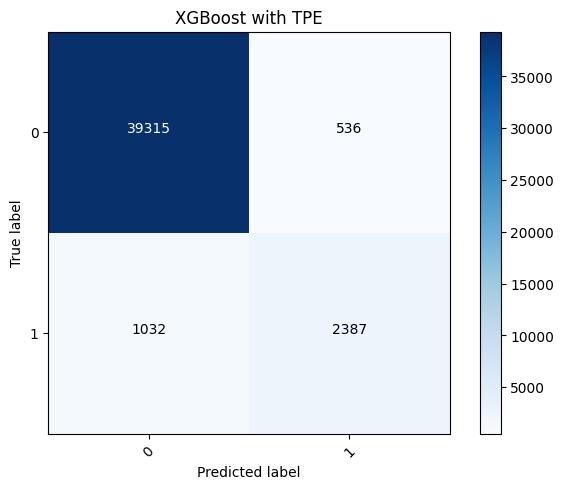

In [104]:
confusion_mtx = confusion_matrix(y_val, y_pred_xgb_tpe.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2), title = "XGBoost with TPE") 

### 5.2.2 XGBoost - cmaes

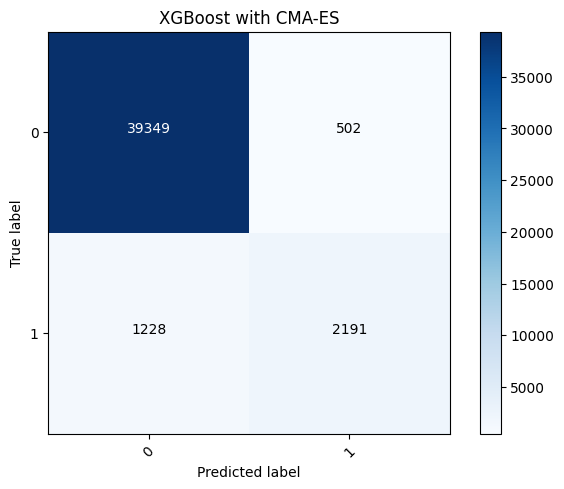

In [106]:
confusion_mtx = confusion_matrix(y_val1, y_pred_xgb_cmaes.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2), title = "XGBoost with CMA-ES") 

### 5.2.3 LightGBM - tpe

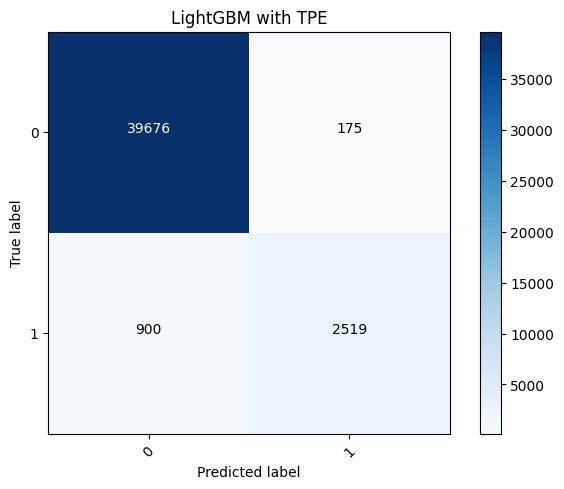

In [107]:
confusion_mtx = confusion_matrix(y_val1, y_pred_lgb_tpe.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2), title = "LightGBM with TPE") 

### 5.2.4 LightGBM - cmaes

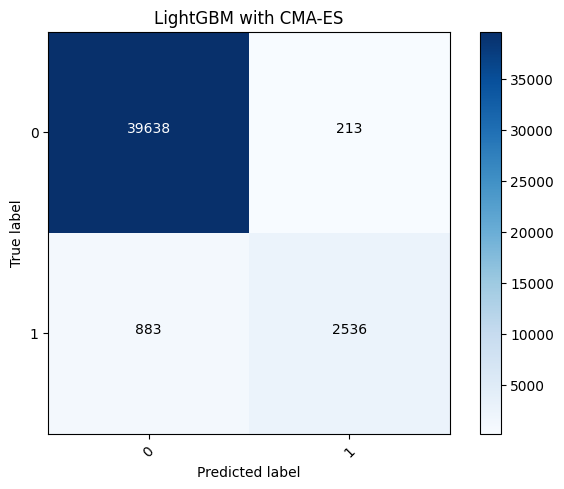

In [108]:
confusion_mtx = confusion_matrix(y_val1, y_pred_lgb_cmaes.round()) 
plot_confusion_matrix(confusion_mtx, classes = range(2), title = "LightGBM with CMA-ES") 

# Transfer svg to pdf

In [ ]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM

In [ ]:
drawing = svg2rlg('viz/dtreeviz/xgb/xgb_show_just_path.svg')
renderPDF.drawToFile(drawing, "viz/dtreeviz/xgb/xgb_show_just_path.pdf")